Here, we redefine the aimc value based on the original Park & Choi (2005) definition of the early type galaxies in the color - color-gradient space:

\begin{equation}
  \text{aimc} = \tan^{-1} \left( \frac{-\Delta (g-i) + \overline{\Delta (g-i)}}{(u-r) - \overline{(u-r)}} \right) + 90^\circ
\end{equation}

Where $\overline{\Delta (g-i)} = -0.106$ and $\overline{(u-r)} = 2.34$ (based on the KIAS-VAGC photometry in SDSS DR7).

In [1]:
from astropy.table import Table, vstack

import numpy as np

from scipy.stats import norm, skewnorm
from scipy.special import factorial, gamma, gammaln
import scipy.integrate as inte
from scipy.optimize import curve_fit, minimize, root_scalar

import dynesty
from dynesty import plotting as dyplot

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data import

In [2]:
galaxy_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_correctVflag.txt'

galaxies = Table.read(galaxy_filename, format='ascii.commented_header')

Remove galaxies with failed photometry
- $u - r < -35$
- $\Delta (g - i) = -10, -9, 99$

In [3]:
good_galaxies = galaxies[galaxies['u_r'] > -35]

good_galaxies = good_galaxies[good_galaxies['cd'] != -10]
good_galaxies = good_galaxies[good_galaxies['cd'] != -9]
good_galaxies = good_galaxies[good_galaxies['cd'] != 99]

# Calculate my aimc

Defining the zero-point of aimc to be either the average or median position of all the objects in this space.

In [4]:
grad_shift = np.mean(good_galaxies['cd'])
color_shift = np.mean(good_galaxies['u_r'])

grad_shift_median = np.median(good_galaxies['cd'])
color_shift_median = np.median(good_galaxies['u_r'])

print('Gradient center point (avg, median):', grad_shift, grad_shift_median)
print('Color center point (avg, median):', color_shift, color_shift_median)

Gradient center point (avg, median): -0.10595822288483468 -0.112
Color center point (avg, median): 2.3363243168695527 2.484


In [5]:
def my_aimc(grad, color):
    
    #grad_shift = 0
    #color_shift = 2
    
    #aimc = np.arctan2(-grad + grad_shift, color - color_shift) + 0.5*np.pi
    aimc = np.arctan2(-grad + grad_shift_median, color - color_shift_median) + 0.5*np.pi
    
    # Need to convert from radians to degrees
    aimc = aimc*180/np.pi
    
    # Need to map [-180,0) to [180,360)
    aimc[aimc < 0] += 360
    
    return aimc

In [6]:
galaxies['my_aimc'] = my_aimc(galaxies['cd'], galaxies['u_r'])
good_galaxies['my_aimc'] = my_aimc(good_galaxies['cd'], good_galaxies['u_r'])

##### Magnitude bins

In [7]:
boolean_14p5_16 = galaxies['prmag'] < 16
boolean_16_16p5 = np.logical_and(galaxies['prmag'] >= 16, galaxies['prmag'] < 16.5)
boolean_16p5_17 = np.logical_and(galaxies['prmag'] >= 16.5, galaxies['prmag'] < 17)
boolean_17_17p5 = galaxies['prmag'] >= 17

In [8]:
ur_bins = np.linspace(0, 4, 100)

<IPython.core.display.Javascript object>


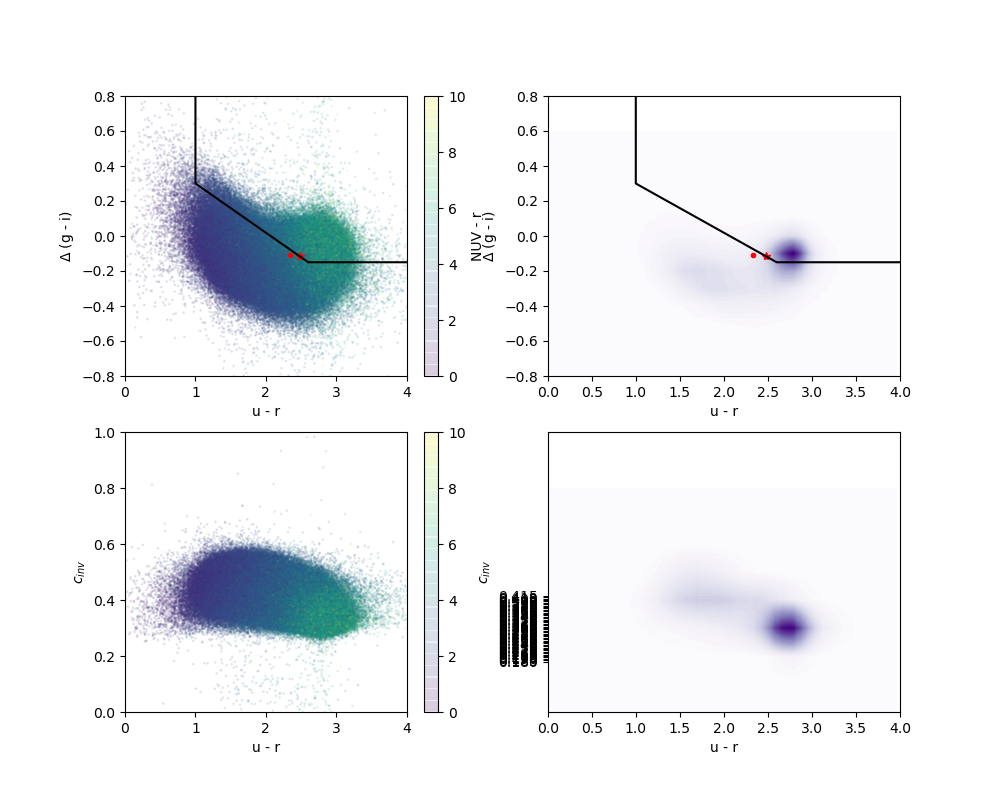

In [9]:
%matplotlib notebook

plt.figure(figsize=(10,8))

plt.subplot(221)
plt.scatter(galaxies['u_r'], galaxies['cd'], s=1, c=galaxies['NUV_r'], alpha=0.1)
plt.plot(np.mean(good_galaxies['u_r']), np.mean(good_galaxies['cd']), 'r.')
plt.plot(np.median(good_galaxies['u_r']), np.median(good_galaxies['cd']), 'r*')

plt.plot([1,1,2.6,4], [0.8,0.3,-0.15,-0.15], 'k')

cbar = plt.colorbar()
plt.clim(0,10)
cbar.ax.set_ylabel('NUV - r')
#plt.clim(0,360)
#cbar.ax.set_ylabel('aimc')
#plt.clim(0,1)
#cbar.ax.set_ylabel('$c_{inv}$')

plt.axis([0, 4, -0.8, 0.8])

plt.xlabel('u - r')
plt.ylabel('$\Delta$ (g - i)')


plt.subplot(222)

A_N, Cedges, Gedges = np.histogram2d(good_galaxies['u_r'], good_galaxies['cd'], 
                                     bins=(ur_bins, np.arange(-0.8, 0.8, 0.1)))
Cmesh, Gmesh = np.meshgrid(Cedges[:-1], Gedges[:-1], indexing='ij')

plt.contourf(Cmesh, Gmesh, A_N, 50, cmap=cm.get_cmap('Purples'))
plt.plot(np.mean(good_galaxies['u_r']), np.mean(good_galaxies['cd']), 'r.')
plt.plot(np.median(good_galaxies['u_r']), np.median(good_galaxies['cd']), 'r*')

plt.plot([1,1,2.6,4], [0.8,0.3,-0.15,-0.15], 'k')

plt.axis([0, 4, -0.8, 0.8])

plt.xlabel('u - r')
plt.ylabel('$\Delta$ (g - i)')



plt.subplot(223)

plt.scatter(galaxies['u_r'], galaxies['conx1'], s=1, c=galaxies['NUV_r'], alpha=0.1)

plt.colorbar()
plt.clim((0,10))

plt.axis([0, 4, 0, 1])

plt.xlabel('u - r')
plt.ylabel('$c_{inv}$')




plt.subplot(224)

B_N, Cedges2, Iedges = np.histogram2d(galaxies['u_r'][boolean_17_17p5], 
                                      galaxies['conx1'][boolean_17_17p5], 
                                      bins=(ur_bins, np.arange(0, 1, 0.1)))
Cmesh2, Imesh = np.meshgrid(Cedges2[:-1], Iedges[:-1], indexing='ij')

plt.contourf(Cmesh2, Imesh, B_N, 50, cmap=cm.get_cmap('Purples'))

plt.gca().set_yticks(np.arange(0.18, 0.42, 0.005))

#plt.grid(which='both')

plt.axis([0, 4, 0, 1])
#plt.axis([2.5, 3, 0.18, 0.42])

plt.xlabel('u - r')
plt.ylabel('$c_{inv}$');

<IPython.core.display.Javascript object>


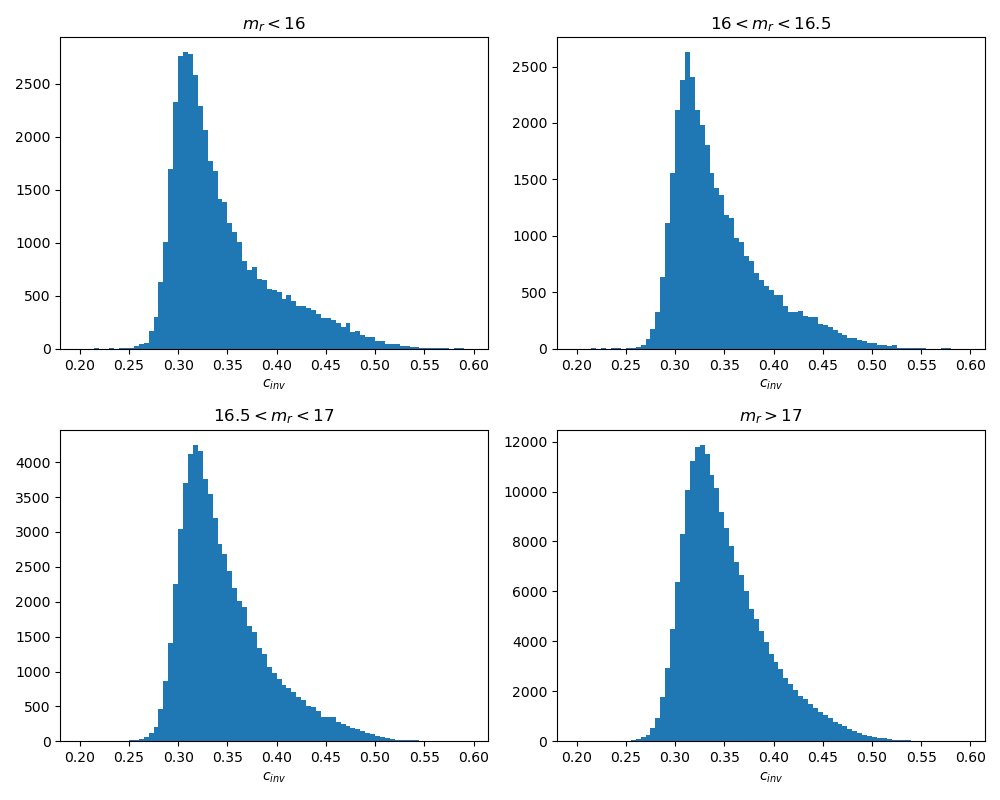

In [10]:
%matplotlib notebook

color_boolean = np.logical_and(galaxies['u_r'] > 2.5, galaxies['u_r'] < 3.5)
cinv_bins = np.arange(0.2, 0.6, 0.005)
cinv_centers = 0.5*(cinv_bins[1:] + cinv_bins[:-1])

plt.figure(figsize=(10,8))

################################################################################
# Brightest galaxies
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.hist(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16 < mr < 16.5
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.hist(galaxies['conx1'][boolean_16_16p5 & color_boolean], bins=cinv_bins)

plt.title('$16 < m_r < 16.5$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16.5 < mr < 17
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.hist(galaxies['conx1'][boolean_16p5_17 & color_boolean], bins=cinv_bins)

plt.title('$16.5 < m_r < 17$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# Faintest galaxies
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.hist(galaxies['conx1'][boolean_17_17p5 & color_boolean], bins=cinv_bins)

plt.title('$m_r > 17$')
plt.xlabel('$c_{inv}$')
################################################################################

plt.tight_layout();


## Continuous Poisson distribution

\begin{equation}
  P(x;\lambda) = A \frac{\lambda^x e^{-\lambda}}{\Gamma (x + 1)}
\end{equation}

In [110]:
def Poisson(lam, x):
#def Poisson(x, A, l):
    '''
    Poisson distribution
    '''
    l = lam[0]
    
    return (l**x)*np.exp(-l)/(gamma(x + 1))

<IPython.core.display.Javascript object>


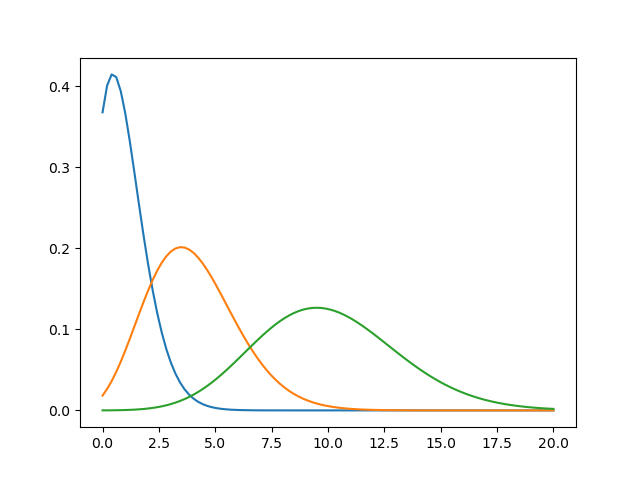

In [102]:
%matplotlib notebook

plt.figure()

x = np.linspace(0,20, 100)
plt.plot(x, Poisson([1, 1], x))
plt.plot(x, Poisson([1, 4], x))
plt.plot(x, Poisson([1, 10], x));

### Maximum Likelihood Result

From Segev's notebook: https://github.com/sybenzvi/mixture-models/blob/master/mixturemodel_color_skew.ipynb

In [21]:
def logL_Poisson(params, m, x):
    """Log-likelihood of the data set using the Poisson distribution.
    
    Parameters
    ----------
    params : list or ndarray
        List of 2 parameters: lambda and scale coefficient.
    m : ndarray
        Binned counts in data set.
    x : ndarray
        Bin centers used to construct the histogrammed counts m.
        
    Returns
    -------
    logL : float
        Log likelihood of set m given model parameters.
    """
    
    lambda1 = Poisson(params, x)
    lambda1[lambda1<=0] = np.finfo(dtype=np.float64).tiny
    
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m + 1))



def nlogL_Poisson(params, m, x):
    """Negative log-likelihood, for minimizers."""
    return -logL_Poisson(params, m, x)

### Least squares

In [46]:
def lsq_Poisson(params, m, x):
    '''
    Least squares of the Poisson model
    '''
    
    lambda1 = Poisson(params, x)
    
    residuals = lambda1 - m
    
    return np.sum(residuals*residuals)

### Nested sampling of the likelihood and priors

In [29]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u

def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u

def prior_xforPoisson(u):
    """Priors for the 2 parameters of the Poisson model. Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    A       = uniform(0., 15., u[0])
    l       = uniform(0., 1., u[1])
    
    return A, l

#### Parameter bounds

In [105]:
param_bounds = [#[0., 100.],  # A ....... amplitude
                [0., 10.]]    # lambda .. rate

##### Brightest galaxies

In [111]:
dist,_ = np.histogram(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)
dist_norm = 0.4*dist/np.max(dist)

# Generate 10 random seeds for the minimizer.
# Store the result with the lowest -ln(L) in bestfit.
bestfit = None

print(dist_norm)
print(cinv_centers)

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in param_bounds]
    result = minimize(nlogL_Poisson, p0, method='L-BFGS-B', args=(dist_norm, 15*(cinv_centers-0.2)), bounds=param_bounds)
    #result = minimize(lsq_Poisson, p0, method='L-BFGS-B', args=(dist, cinv_centers), bounds=param_bounds)
    
    if result.success:
        print(p0)
        print('   {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result
                
print(bestfit)

'''
popt, pcov = curve_fit( Poisson, 
                        cinv_centers, 
                        dist, 
                        bounds=([param_bounds[0][0], param_bounds[1][0]], 
                                [param_bounds[0][1], param_bounds[1][1]])
                      )

popt
''';

[4.28877770e-04 2.85918513e-04 1.42959257e-04 7.14796283e-04
 2.85918513e-04 1.42959257e-04 7.14796283e-04 1.42959257e-04
 1.14367405e-03 8.57755540e-04 1.42959257e-03 3.28806290e-03
 6.29020729e-03 8.43459614e-03 2.34453181e-02 4.28877770e-02
 9.06361687e-02 1.44245890e-01 2.42601858e-01 3.33095068e-01
 3.94853467e-01 4.00000000e-01 3.97426733e-01 3.69406719e-01
 3.27233738e-01 2.95639743e-01 2.53609721e-01 2.40171551e-01
 2.02001430e-01 1.98427448e-01 1.69263760e-01 1.58112938e-01
 1.43388134e-01 1.18227305e-01 1.05932809e-01 1.10507505e-01
 9.43531094e-02 9.22087205e-02 8.04860615e-02 7.96283059e-02
 7.61972838e-02 6.69049321e-02 7.26233024e-02 6.46175840e-02
 5.76125804e-02 5.83273767e-02 5.51822731e-02 5.17512509e-02
 4.64617584e-02 4.13152252e-02 4.13152252e-02 3.85989993e-02
 3.43102216e-02 2.91636883e-02 3.47390994e-02 2.24446033e-02
 2.38741959e-02 1.91565404e-02 1.61543960e-02 1.52966405e-02
 1.07219442e-02 1.01501072e-02 7.14796283e-03 6.00428878e-03
 6.43316655e-03 3.859899

<IPython.core.display.Javascript object>


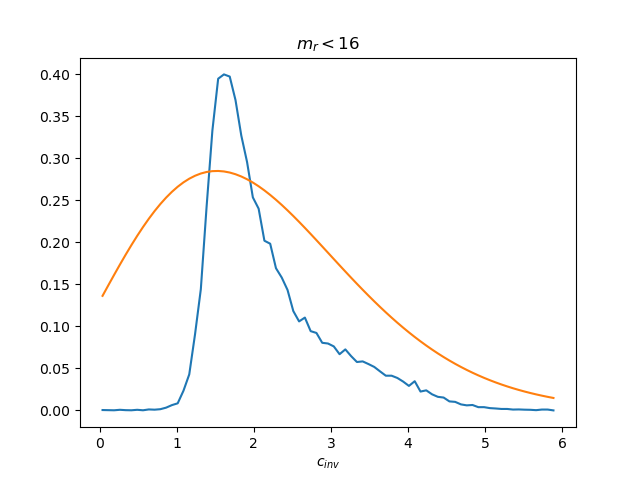

In [112]:
cinv_range = np.linspace(0,1,1000)

%matplotlib notebook

plt.figure()

#plt.hist(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)
plt.plot(15*(cinv_centers-0.2), dist_norm)

#plt.plot(cinv_range, Poisson([1, 0.0000002], cinv_range))
plt.plot(15*(cinv_centers-0.2), Poisson(bestfit.x, 15*(cinv_centers-0.2)))
#plt.plot(cinv_range, Poisson(cinv_range, popt[0], popt[1]))

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')

plt.tight_layout;

In [31]:
dsampler = dynesty.DynamicNestedSampler(logL_Poisson, prior_xforPoisson, ndim=2,
                                        logl_args=(dist, cinv_centers),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

24212it [03:35, 112.34it/s, batch: 12 | bound: 81 | nc: 3 | ncall: 116927 | eff(%): 20.707 | loglstar: -220.960 < -219.363 < -219.734 | logz: -225.104 +/-  0.092 | stop:  0.938]    


<IPython.core.display.Javascript object>


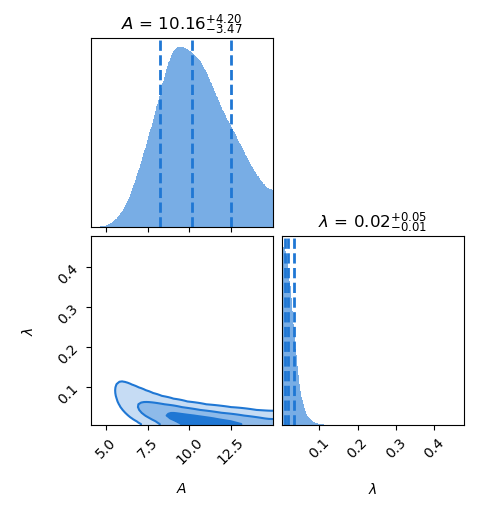

In [32]:
%matplotlib notebook

labels = ['$A$', r'$\lambda$']

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(2, 2, figsize=(2.5*2,2.6*2)),
                              color='#1f77d4')

## Exponentially modified Gaussian distribution

\begin{equation}
  f(x; \mu, \sigma, \lambda) = \frac{\lambda}{2} e^{\frac{\lambda}{2} (2\mu + \lambda \sigma^2 - 2x)} \text{erfc}\left( \frac{\mu + \lambda \sigma^2 - x}{\sqrt{2}\sigma}\right)
\end{equation}

where

\begin{equation}
  \text{erfc}(x) = 1 - \text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_x^\infty e^{-t^2} \, dt
\end{equation}

In [120]:
#def exGaussian(x, mu, sigma, l):
def exGaussian(params, x):
    '''
    Exponentially modified Gaussian distribution
    '''
    
    A, mu, sigma, l = params
    
    erfc_integrand = lambda t: (2/np.sqrt(np.pi))*np.exp(-t*t)
    
    y = (mu + l*sigma*sigma - x)/(np.sqrt(2)*sigma)
    
    if isinstance(x, float):
        
        erfc, erfc_err = inte.quad(erfc_integrand, y, np.inf)
    else:
        erfc = np.zeros(len(x))
        erfc_err = np.zeros(len(x))
        
        for i in range(len(x)):
            erfc[i], erfc_err[i] = inte.quad(erfc_integrand, y[i], np.inf)
    
    return A*0.5*l*np.exp(0.5*l*(2*mu + l*sigma*sigma - 2*x))*erfc

<IPython.core.display.Javascript object>


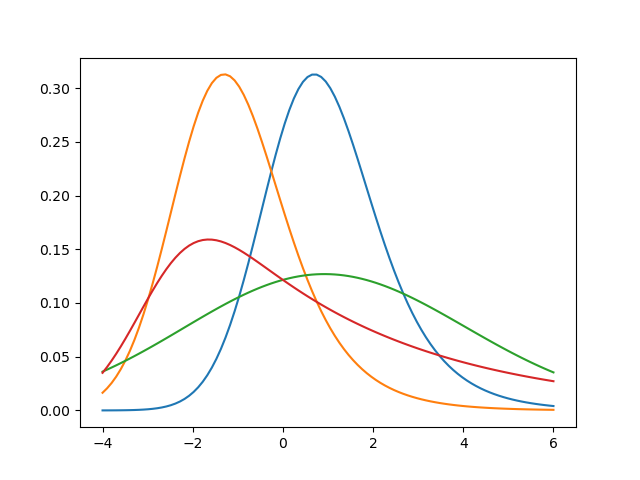

In [130]:
%matplotlib notebook

plt.figure()

x = np.linspace(-4,6, 100)
plt.plot(x, exGaussian([1, 0, 1, 1], x))
plt.plot(x, exGaussian([1, -2, 1, 1], x))
plt.plot(x, exGaussian([1, 0, 3, 1], x))
plt.plot(x, exGaussian([1, -3, 1, 0.25], x));

### Maximum Likelihood Result

From Segev's notebook: https://github.com/sybenzvi/mixture-models/blob/master/mixturemodel_color_skew.ipynb

In [114]:
def logL_exGaussian(params, m, x):
    """Log-likelihood of the data set for the exponential Gaussian model.
    
    Parameters
    ----------
    params : list or ndarray
        List of 2 parameters: lambda and scale coefficient.
    m : ndarray
        Binned counts in data set.
    x : ndarray
        Bin centers used to construct the histogrammed counts m.
        
    Returns
    -------
    logL : float
        Log likelihood of set m given model parameters.
    """
    
    lambda1 = exGaussian(params, x)
    lambda1[lambda1<=0] = np.finfo(dtype=np.float64).tiny
    
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m + 1))



def nlogL_exGaussian(params, m, x):
    """Negative log-likelihood, for minimizers."""
    return -logL_exGaussian(params, m, x)

### Nested sampling of the likelihood and priors

In [138]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u

def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u

def prior_xforexGaussian(u):
    """Priors for the 2 parameters of the expoential Gaussian model. Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    A     = jeffreys(1., 1e4, u[0])
    mu    = uniform(0.1, 1., u[1])
    sigma = jeffreys(0., 10., u[2])
    l     = uniform(0., 10., u[3])
    
    return A, mu, sigma, l

#### Parameter bounds

In [125]:
param_bounds = [[1., 1e4],  # A ....... amplitude
                [0., 1.],   # mu ...... mean
                [0., 10.],  # sigma ... standard deviation
                [0., 10.]]  # lambda .. rate

##### Brightest galaxies

In [126]:
dist,_ = np.histogram(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)

# Generate 10 random seeds for the minimizer.
# Store the result with the lowest -ln(L) in bestfit.
bestfit = None

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in param_bounds]
    result = minimize(nlogL_exGaussian, p0, method='L-BFGS-B', args=(dist, cinv_centers), bounds=param_bounds)
    #result = minimize(lsq_Poisson, p0, method='L-BFGS-B', args=(dist, cinv_centers), bounds=param_bounds)
    
    if result.success:
        print(p0)
        print('   {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result
                
print(bestfit)

/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[3756.7909362652936, 0.6084768268368353, 2.4321887627591474, 4.398597904132366]
   35208.87


/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in subtract


[6431.29012807677, 0.7975589905937526, 6.266555451272521, 2.283218142635044]
   35547.69
[1558.8889499597249, 0.3623106677845165, 2.426899124947127, 9.276713618278567]
   36736.59
[4510.241842198855, 0.8620588351042352, 7.25273621970493, 2.0958712321042485]
   28480.48
[988.4260747058029, 0.5292922587903477, 4.539131952980262, 1.1158606448135178]
   34177.77
[4279.397105022308, 0.8142435331680639, 1.3172630561688892, 5.37207170742983]
   35497.56
[2715.1159446678366, 0.6975520235523012, 8.956039123890148, 1.8775964742157658]
   36833.42
[1211.7485368721839, 0.8449734464556264, 1.6364108209779848, 2.4569245055948965]
   35145.77


/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


[2612.6623543301616, 0.3393758661888947, 0.29281667992516525, 4.626674509239319]
   33249.68
[2811.5990472390463, 0.25044114725019195, 2.6142770203781196, 3.277571074353655]
   35218.61
[4111.528664662896, 0.9718551656986392, 8.46661680141749, 0.8370407119701151]
   30038.22
[3629.487884869942, 0.8021647205234246, 9.179483871269092, 2.8829995188696413]
   37894.80
[298.82264046808854, 0.8451039221611115, 6.855407685811221, 0.27479193660092216]
   30992.99
      fun: 28480.484302471912
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.57168722e+00,  6.37798294e+03,  1.96697136e+04, -1.70892599e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 325
      nit: 31
   status: 0
  success: True
        x: array([6.09687359e+02, 4.04797297e-02, 2.31558327e-01, 1.00000000e+01])


<IPython.core.display.Javascript object>


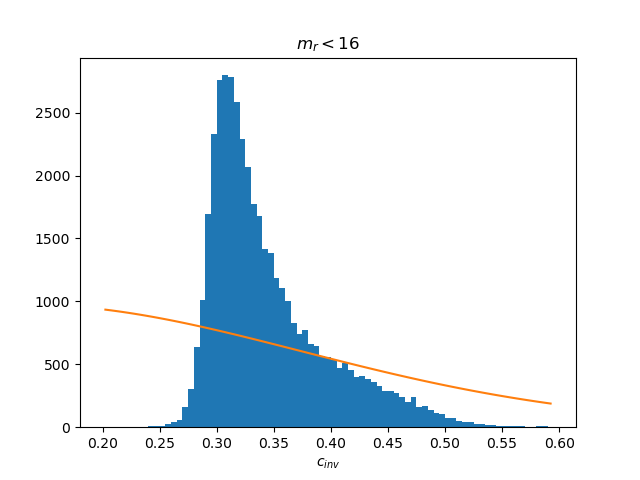

In [137]:
cinv_range = np.linspace(0,1,1000)

%matplotlib notebook

plt.figure()

plt.hist(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)

plt.plot(cinv_centers, exGaussian(bestfit.x, cinv_centers))
#plt.plot(cinv_range, Poisson(cinv_range, popt[0], popt[1]))
#plt.plot(cinv_centers, exGaussian([2750, 0.325, 0.1, 0.1], cinv_centers))

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')

plt.tight_layout;

In [140]:
dsampler = dynesty.DynamicNestedSampler(logL_exGaussian, prior_xforexGaussian, ndim=4,
                                        logl_args=(dist, cinv_centers),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

0it [00:00, ?it/s]/Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
1887it [07:24,  2.15s/it, batch: 0 | bound: 0 | nc: 73 | ncall: 18383 | eff(%):  9.993 | loglstar:   -inf < -45538.276 <    inf | logz: -45548.954 +/-  0.207 | dlogz: 14554.066 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
2213it [08:10,  7.45it/s, batch: 0 | bound: 1 | nc: 2 | ncall: 19132 | eff(%): 11.272 | loglstar:   -inf < -37516.881 <    inf | logz: -37528.210 +/-  0.213 | dlogz: 6535.965 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_

Exception while calling loglikelihood function:
  params: [3.57978569e+02 1.27232906e-01 0.00000000e+00 4.22862483e+00]
  args: (array([   3,    2,    1,    5,    2,    1,    5,    1,    8,    6,   10,
         23,   44,   59,  164,  300,  634, 1009, 1697, 2330, 2762, 2798,
       2780, 2584, 2289, 2068, 1774, 1680, 1413, 1388, 1184, 1106, 1003,
        827,  741,  773,  660,  645,  563,  557,  533,  468,  508,  452,
        403,  408,  386,  362,  325,  289,  289,  270,  240,  204,  243,
        157,  167,  134,  113,  107,   75,   71,   50,   42,   45,   27,
         27,   19,   16,   12,   12,    7,    8,    6,    5,    2,    7,
          7,    0]), array([0.2025, 0.2075, 0.2125, 0.2175, 0.2225, 0.2275, 0.2325, 0.2375,
       0.2425, 0.2475, 0.2525, 0.2575, 0.2625, 0.2675, 0.2725, 0.2775,
       0.2825, 0.2875, 0.2925, 0.2975, 0.3025, 0.3075, 0.3125, 0.3175,
       0.3225, 0.3275, 0.3325, 0.3375, 0.3425, 0.3475, 0.3525, 0.3575,
       0.3625, 0.3675, 0.3725, 0.3775, 0.3825, 0.3875, 

KeyboardInterrupt: 

This is going to take 25 hours!

<IPython.core.display.Javascript object>


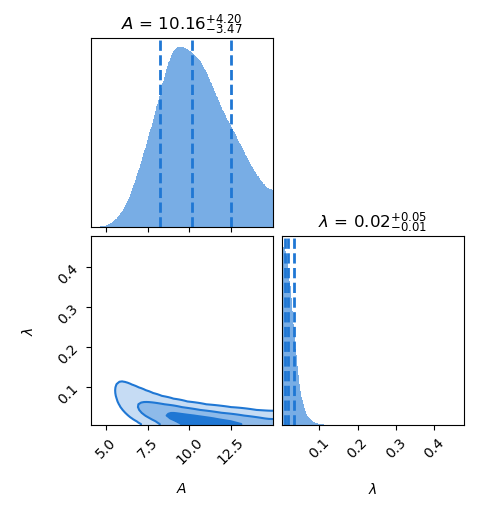

In [32]:
%matplotlib notebook

labels = ['$A$', r'$\mu$', r'$\sigma$', r'$\lambda$']
nParams = 4

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams,2.6*nParams)),
                              color='#1f77d4')

## Sum of Gaussian and skew-normal distribution

\begin{equation}
  f(x; \alpha, \mu_\alpha, \sigma_\alpha, \beta, \mu_\beta, \sigma_\beta, \xi_\beta) = \alpha \phi(z_\alpha) + \beta \phi(z_\beta) \Phi(\xi_\beta z_\beta)
\end{equation}

where $z = (x - \mu)/\sigma$, $\phi$ is the standard normal distribution, and $\Phi$ is the standard normal CDF.

In [142]:
def Gaussian_skewNorm(params, x):
    '''
    Mixture of a standard normal distribution and a skew normal distribution.
    '''
    
    a, mu_a, sigma_a = params[:3]
    b, mu_b, sigma_b, skew_b = params[3:]
    
    return a*norm.pdf(x, loc=mu_a, scale=sigma_a) + b*skewnorm.pdf(x, skew_b, loc=mu_b, scale=sigma_b)


def logL_GaussianSkewNorm(params, m, x):
    """Log-likelihood of the data set for the Gaussian and skew normal mixture model.
    
    Parameters
    ----------
    params : list or ndarray
        List of 7 parameters.
    m : ndarray
        Binned counts in data set.
    x : ndarray
        Bin centers used to construct the histogrammed counts m.
        
    Returns
    -------
    logL : float
        Log likelihood of set m given model parameters.
    """
    
    lambda1 = Gaussian_skewNorm(params, x)
    lambda1[lambda1<=0] = np.finfo(dtype=np.float64).tiny
    
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m + 1))



def nlogL_GaussianSkewNorm(params, m, x):
    """Negative log-likelihood, for minimizers."""
    return -logL_GaussianSkewNorm(params, m, x)

<IPython.core.display.Javascript object>


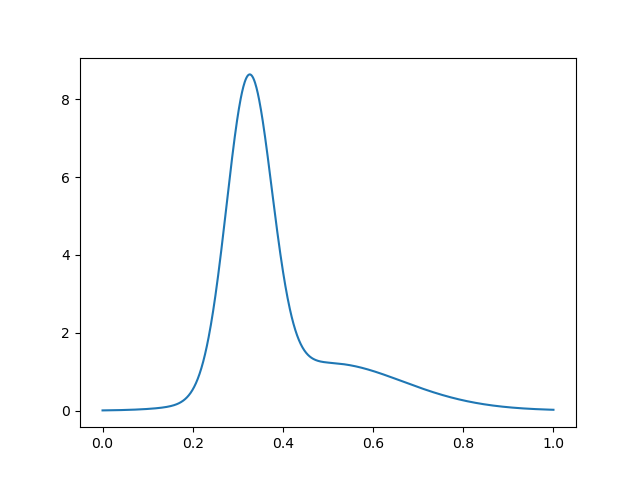

In [153]:
%matplotlib notebook

x = np.linspace(0,1, 1000)

plt.figure()

plt.plot(x, Gaussian_skewNorm([1, 0.325, 0.05, 0.5, 0.4, 0.2, 1], x))

### Nested sampling of the likelihood and priors

In [175]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u

def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u

def prior_xforGaussianSkewNorm(u):
    """Priors for the 2 parameters of the Gaussian and skew normal misture model. 
    Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    a       = jeffreys(1., 1e4, u[0])
    mu_a    = uniform(0.2, 0.4, u[1])
    sigma_a = jeffreys(0.001, 3., u[2])
    b       = jeffreys(1., 1e4, u[3])
    mu_b    = uniform(0.3, 1., u[4])
    sigma_b = jeffreys(0.001, 3., u[5])
    skew_b  = uniform(-10., 10., u[6])
    
    return a, mu_a, sigma_a, b, mu_b, sigma_b, skew_b

#### Brightest galaxies
#### Parameter bounds

In [195]:
param_bounds = [[10., 3000.],  # a ......... normal amplitude
                [0.25, 0.35],  # mu_a ...... normal mean
                [0.01, 3.0],   # sigma_a ... normal standard deviation
                [10., 3000.],  # b ......... skew normal amplitude
                [0.35, 0.5],   # mu_b ...... skew normal mean
                [0.01, 3.0],   # sigma_b ... skew normal standard deviation
                [-40., 40.]    # skew_b .... skew normal skew
               ]

In [196]:
dist,_ = np.histogram(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)

# Generate 10 random seeds for the minimizer.
# Store the result with the lowest -ln(L) in bestfit.
bestfit = None

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in param_bounds]
    result = minimize(nlogL_GaussianSkewNorm, 
                      p0, 
                      method='L-BFGS-B', 
                      args=(dist, cinv_centers), 
                      bounds=param_bounds)
    #result = minimize(lsq_Poisson, p0, method='L-BFGS-B', args=(dist, cinv_centers), bounds=param_bounds)
    
    if result.success:
        #print(p0)
        #print('   {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result
                
print(bestfit)

[1369.8013174884854, 0.32242602656041036, 2.702341331510974, 642.8903440390711, 0.3562334192768305, 2.602805776465642, -4.073015140151838]
   7769.71
[881.2427739373163, 0.3336431231116528, 1.4259605968389586, 1021.7582609161909, 0.3625564887283359, 2.34004915933228, 0.23466462387364828]
   22267.85
[1440.5942461500317, 0.27491409860825655, 1.80559504350862, 2237.576767489528, 0.4093699703633762, 2.984910895436119, 13.714951346921154]
   24452.69
[2475.40183114269, 0.33220177801955625, 1.0601953110390114, 999.8130537961166, 0.37756283789927775, 1.9515275710163391, -3.771449770288527]
   26245.90
[1211.3545790599258, 0.27694642763325217, 2.8476078848219677, 1251.9459560781904, 0.35573970474562133, 2.721638997052711, -6.239511073349149]
   7760.79
[2869.1007426768356, 0.315956355312517, 0.6971903008642729, 2605.4216782621206, 0.4564699693085138, 0.08851328896760319, 4.640473167006661]
   7771.63
[2010.9374673279917, 0.2808540481699263, 0.9072489318201394, 2703.427858285358, 0.44299833424

<IPython.core.display.Javascript object>


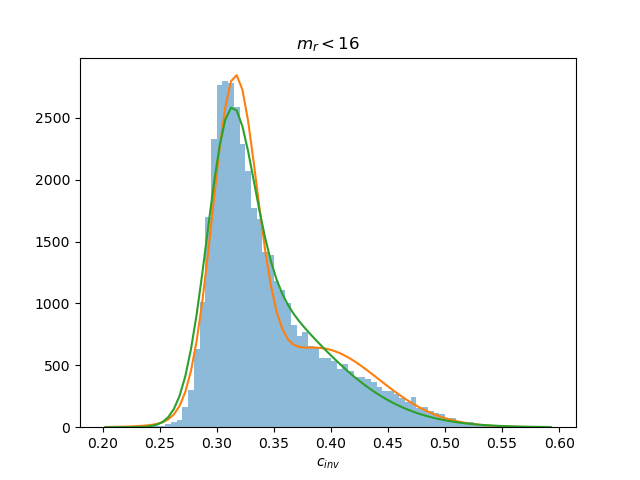

In [197]:
cinv_range = np.linspace(0,1,1000)

%matplotlib notebook

plt.figure()

plt.hist(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins, alpha=0.5)

plt.plot(cinv_centers, Gaussian_skewNorm(bestfit.x, cinv_centers))
plt.plot(cinv_centers, Gaussian_skewNorm([84.91, 0.31, 0.02, 127.15, 0.30, 0.08, 3.72], cinv_centers))

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')

plt.tight_layout;

In [176]:
dsampler = dynesty.DynamicNestedSampler(logL_GaussianSkewNorm, 
                                        prior_xforGaussianSkewNorm, 
                                        ndim=7,
                                        logl_args=(dist, cinv_centers),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

32370it [3:23:06,  2.66it/s, batch: 7 | bound: 19342 | nc: 1 | ncall: 14819297 | eff(%):  0.218 | loglstar: -602.425 < -594.885 < -596.511 | logz: -633.296 +/-  0.369 | stop:  0.965]            


<IPython.core.display.Javascript object>


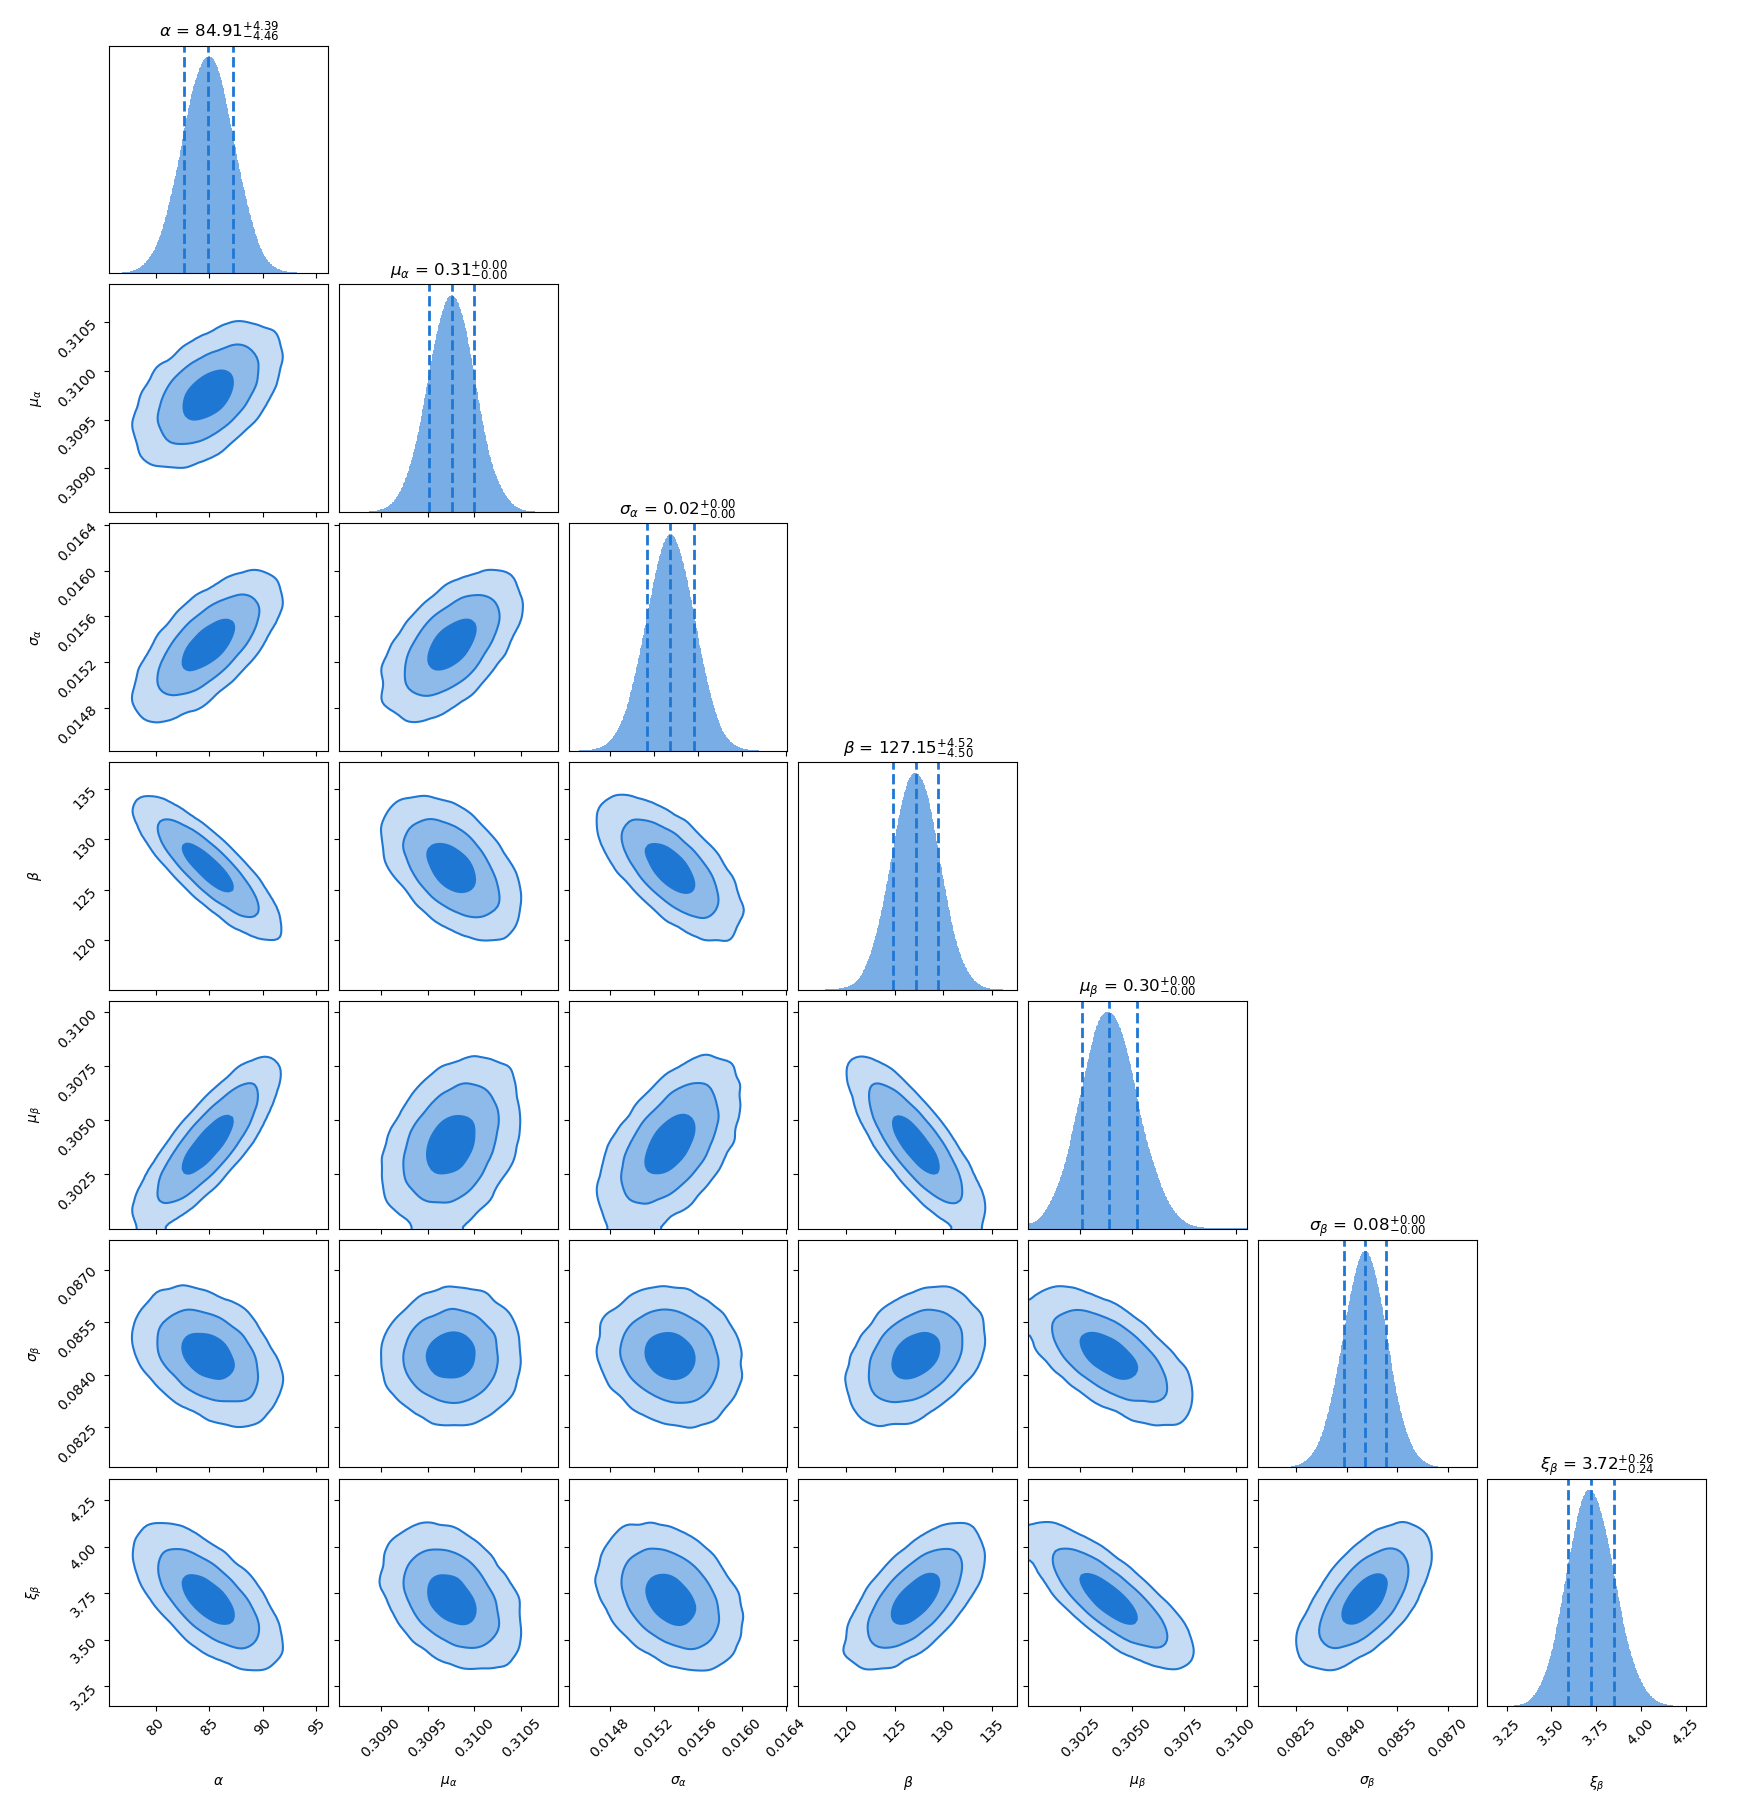

In [177]:
labels = [r'$\alpha$', r'$\mu_\alpha$', r'$\sigma_\alpha$', 
          r'$\beta$', r'$\mu_\beta$', r'$\sigma_\beta$', r'$\xi_\beta$']
nParams = len(labels)

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams,2.6*nParams)),
                              color='#1f77d4')

## Sum of skew-normal distribution mixture

\begin{equation}
  f(x; \alpha, \mu_\alpha, \sigma_\alpha, \xi_\alpha, \beta, \mu_\beta, \sigma_\beta, \xi_\beta) = \alpha \phi(z_\alpha) \Phi(\xi_\alpha z_\alpha) + \beta \phi(z_\beta) \Phi(\xi_\beta z_\beta)
\end{equation}

where $z = (x - \mu)/\sigma$, $\phi$ is the standard normal distribution, and $\Phi$ is the standard normal CDF.

In [11]:
from skewNorms_fit import skewNorms2, skewNorms2_fit, logL_skewNorms2, prior_xforSkewNorms2

<IPython.core.display.Javascript object>


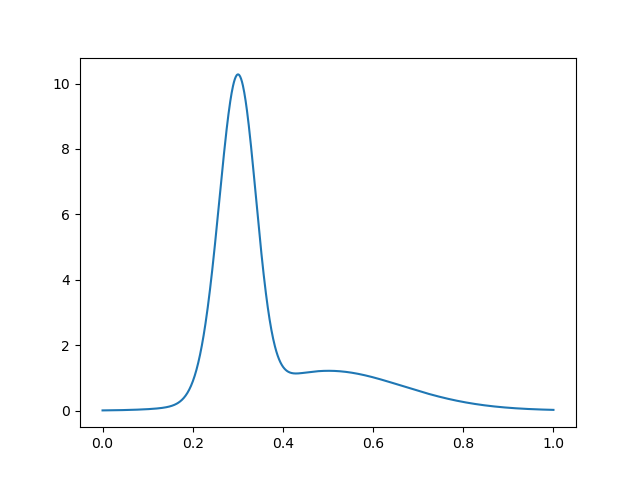

In [12]:
%matplotlib notebook

x = np.linspace(0,1, 1000)

plt.figure()

plt.plot(x, skewNorms2([1, 0.325, 0.05, -1., 0.5, 0.4, 0.2, 1], x));

#### Brightest galaxies parameter bounds

In [15]:
param_bounds = [[10., 300.],  # a ......... skew normal 1 amplitude
                [0.25, 0.35],  # mu_a ...... skew normal 1 mean
                [0.01, 1.0],   # sigma_a ... skew normal 1 standard deviation
                [-10., 10.],   # skew_a .... skew normal 1 skew
                [1., 100.],   # b ......... skew normal 2 amplitude
                [0.35, 0.5],   # mu_b ...... skew normal 2 mean
                [0.01, 1.0],   # sigma_b ... skew normal 2 standard deviation
                [-10., 10.]    # skew_b .... skew normal 2 skew
               ]

In [16]:
dist_bright,_ = np.histogram(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)

bestfit = skewNorms2_fit(cinv_centers, dist_bright, param_bounds)

print(bestfit)

      fun: 340.657745792603
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.62749847e-04,  4.73278305e-02, -2.03091304e+00,  6.92921276e-03,
       -1.13686838e-04,  3.36979156e-01,  1.61600155e+00, -2.22939889e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1899
      nit: 179
   status: 0
  success: True
        x: array([1.40905301e+02, 2.91398977e-01, 3.71716888e-02, 3.61176190e+00,
       7.11070356e+01, 3.57229497e-01, 6.73741924e-02, 9.82669774e-01])


#### $16 < m_r < 16.5$ parameter bounds

In [20]:
param_bounds_16_16p5 = [[10., 300.],  # a ......... skew normal 1 amplitude
                        [0.25, 0.35], # mu_a ...... skew normal 1 mean
                        [0.01, 0.5],  # sigma_a ... skew normal 1 standard deviation
                        [-10., 10.],  # skew_a .... skew normal 1 skew
                        [1., 100.],   # b ......... skew normal 2 amplitude
                        [0.35, 0.5],  # mu_b ...... skew normal 2 mean
                        [0.01, 0.5],  # sigma_b ... skew normal 2 standard deviation
                        [-10., 10.]   # skew_b .... skew normal 2 skew
                       ]

In [21]:
dist_16_16p5,_ = np.histogram(galaxies['conx1'][boolean_16_16p5 & color_boolean], bins=cinv_bins)

bestfit_16_16p5 = skewNorms2_fit(cinv_centers, dist_16_16p5, param_bounds_16_16p5)

print(bestfit_16_16p5)

      fun: 323.5472331352932
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.14956958e-04, -3.10598125e-01,  2.65822564e-01, -7.61701813e-04,
       -1.42108547e-04,  2.32376476e+02, -2.85922397e-03,  2.79669621e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1242
      nit: 104
   status: 0
  success: True
        x: array([1.25488985e+02, 2.94779161e-01, 3.88079383e-02, 3.74165644e+00,
       5.88686581e+01, 3.50000000e-01, 6.53555875e-02, 1.15260981e+00])


#### $16.5 < m_r < 17$ parameter bounds

In [17]:
param_bounds = [[10., 3000.],  # a ......... skew normal 1 amplitude
                [0.25, 0.35],  # mu_a ...... skew normal 1 mean
                [0.01, 3.0],   # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],   # skew_a .... skew normal 1 skew
                [1., 1000.],   # b ......... skew normal 2 amplitude
                [0.35, 0.5],   # mu_b ...... skew normal 2 mean
                [0.01, 3.0],   # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]    # skew_b .... skew normal 2 skew
               ]

In [18]:
dist_16p5_17,_ = np.histogram(galaxies['conx1'][boolean_16p5_17 & color_boolean], bins=cinv_bins)

bestfit_16p5_17 = skewNorms2_fit(cinv_centers, dist_16p5_17, param_bounds)

print(bestfit_16p5_17)

      fun: 335.2179511906695
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.70752343e-04,  7.17329840e-01, -2.57262514e+00,  1.96678229e-02,
       -2.21120899e-03,  7.10692404e+01, -4.00176532e+00,  4.86124918e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3141
      nit: 251
   status: 0
  success: True
        x: array([2.26502786e+02, 2.98159445e-01, 4.08041074e-02, 3.58852945e+00,
       1.02825215e+02, 3.50000000e-01, 6.45806699e-02, 1.11107567e+00])


#### Faint galaxies parameter bounds

In [22]:
param_bounds_faint = [[10., 3000.],  # a ......... skew normal 1 amplitude
                      [0.25, 0.4],   # mu_a ...... skew normal 1 mean
                      [0.01, 3.0],   # sigma_a ... skew normal 1 standard deviation
                      [-30., 30.],   # skew_a .... skew normal 1 skew
                      [1., 1000.],   # b ......... skew normal 2 amplitude
                      [0.35, 0.6],   # mu_b ...... skew normal 2 mean
                      [0.01, 3.0],   # sigma_b ... skew normal 2 standard deviation
                      [-20., 20.]    # skew_b .... skew normal 2 skew
                     ]

In [24]:
dist_faint,_ = np.histogram(galaxies['conx1'][boolean_17_17p5 & color_boolean], bins=cinv_bins)

bestfit_faint = skewNorms2_fit(cinv_centers, dist_faint, param_bounds_faint)

print(bestfit_faint)

      fun: 394.4679737191143
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.72235559e-03,  1.02738852e+01,  1.10487065e+01,  7.96376298e-03,
       -1.98951966e-04, -7.91021648e-01,  1.55550879e+00, -8.87325768e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1737
      nit: 129
   status: 0
  success: True
        x: array([7.06096524e+02, 3.03650219e-01, 4.40450186e-02, 3.19406040e+00,
       2.83390913e+02, 3.57183666e-01, 5.99083240e-02, 8.98885572e-01])


<IPython.core.display.Javascript object>


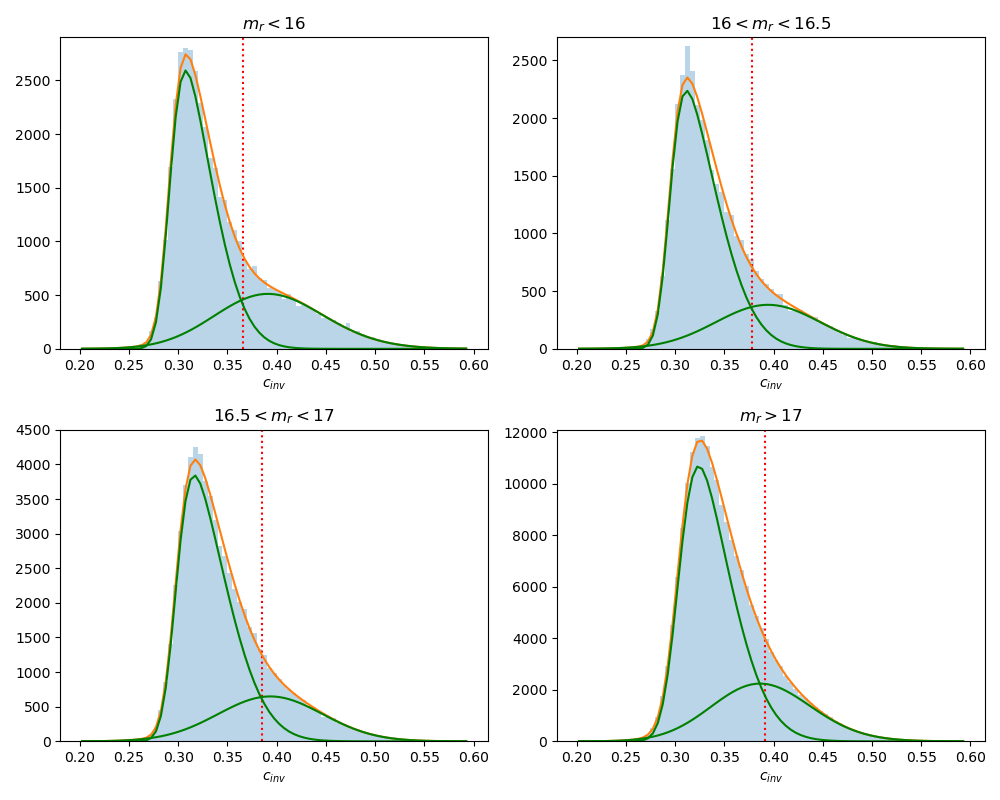

In [52]:
%matplotlib notebook

plt.figure(figsize=(10,8))

################################################################################
# Brightest galaxies
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.hist(galaxies['conx1'][boolean_14p5_16 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit.x[0]*skewnorm.pdf(cinv_centers, bestfit.x[3], loc=bestfit.x[1], scale=bestfit.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit.x[4]*skewnorm.pdf(cinv_centers, bestfit.x[7], loc=bestfit.x[5], scale=bestfit.x[6]), 
        'g')

#plt.plot(cinv_centers,
#         bestfit.x[0]*norm.pdf(cinv_centers, loc=bestfit.x[1], scale=bestfit.x[2]), 
#         'r')
plt.vlines(bestfit.x[1] + 2*bestfit.x[2], 0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2900)

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16 < mr < 16.5
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.hist(galaxies['conx1'][boolean_16_16p5 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16_16p5.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16_16p5.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[3], 
                                           loc=bestfit_16_16p5.x[1], 
                                           scale=bestfit_16_16p5.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16_16p5.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[7], 
                                           loc=bestfit_16_16p5.x[5], 
                                           scale=bestfit_16_16p5.x[6]), 
        'g')

plt.vlines(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2], 
           0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2700)

plt.title('$16 < m_r < 16.5$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16.5 < mr < 17
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.hist(galaxies['conx1'][boolean_16p5_17 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16p5_17.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16p5_17.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[3], 
                                           loc=bestfit_16p5_17.x[1], 
                                           scale=bestfit_16p5_17.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16p5_17.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[7], 
                                           loc=bestfit_16p5_17.x[5], 
                                           scale=bestfit_16p5_17.x[6]), 
        'g')

plt.vlines(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2], 
           0, 4500, colors='r', linestyle='dotted')

plt.ylim(ymax=4500)

plt.title('$16.5 < m_r < 17$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# Faintest galaxies
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.hist(galaxies['conx1'][boolean_17_17p5 & color_boolean], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_faint.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_faint.x[0]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[3], 
                                         loc=bestfit_faint.x[1], 
                                         scale=bestfit_faint.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_faint.x[4]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[7], 
                                         loc=bestfit_faint.x[5], 
                                         scale=bestfit_faint.x[6]), 
        'g')

plt.vlines(bestfit_faint.x[1] + 2*bestfit_faint.x[2], 
           0, 12100, colors='r', linestyle='dotted')

plt.ylim(ymax=12100)

plt.title('$m_r > 17$')
plt.xlabel('$c_{inv}$')
################################################################################


plt.tight_layout();

#### Brightest galaxies

In [207]:
dsampler = dynesty.DynamicNestedSampler(logL_skewNorms, 
                                        prior_xforSkewNorms, 
                                        ndim=8,
                                        logl_args=(dist, cinv_centers),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

36662it [19:21, 31.56it/s, batch: 7 | bound: 1239 | nc: 5 | ncall: 1105985 | eff(%):  3.315 | loglstar: -349.255 < -341.271 < -343.937 | logz: -385.440 +/-  0.396 | stop:  0.905]          


<IPython.core.display.Javascript object>


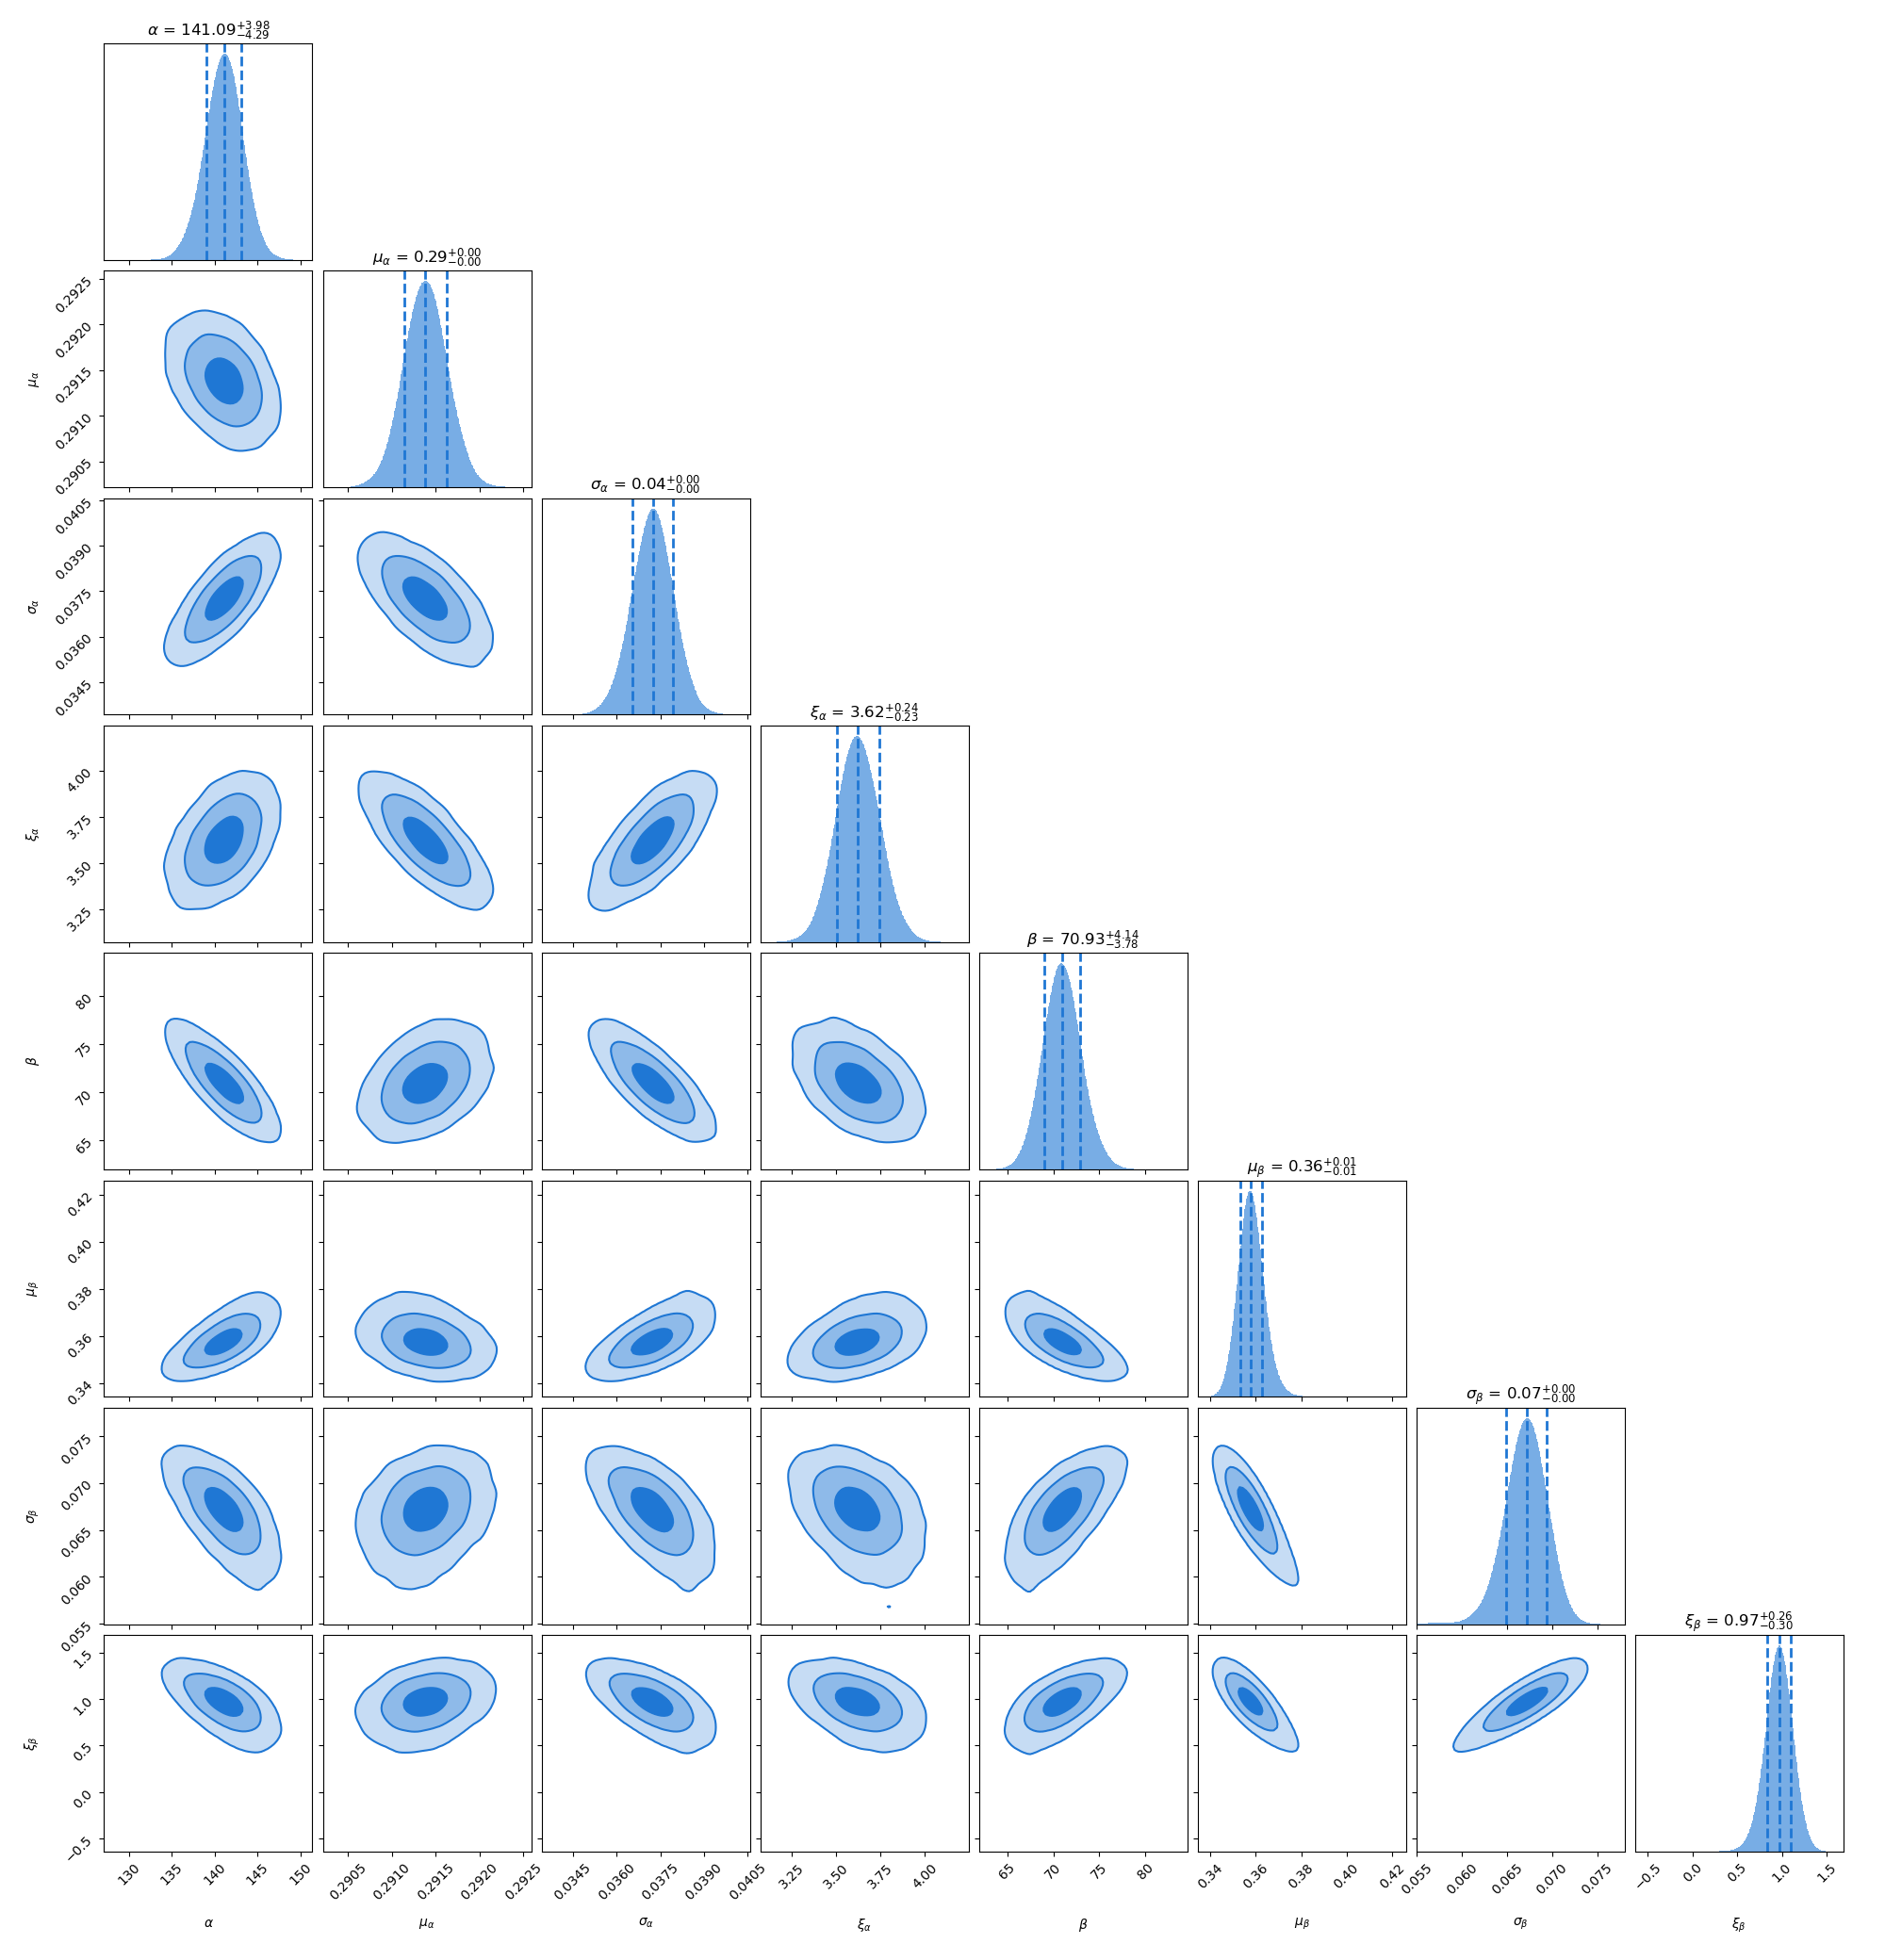

In [208]:
labels = [r'$\alpha$', r'$\mu_\alpha$', r'$\sigma_\alpha$', r'$\xi_\alpha$',
          r'$\beta$', r'$\mu_\beta$', r'$\sigma_\beta$', r'$\xi_\beta$']
nParams = len(labels)

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams,2.6*nParams)),
                              color='#1f77d4')

#### $16 < m_r < 16.5$

In [18]:
dsampler = dynesty.DynamicNestedSampler(logL_skewNorms2, 
                                        prior_xforSkewNorms2, 
                                        ndim=8,
                                        logl_args=(dist_16_16p5, cinv_centers),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

36756it [33:57, 18.04it/s, batch: 7 | bound: 3117 | nc: 1 | ncall: 2412904 | eff(%):  1.523 | loglstar: -330.899 < -322.980 < -324.777 | logz: -366.072 +/-  0.391 | stop:  0.968]           


<IPython.core.display.Javascript object>


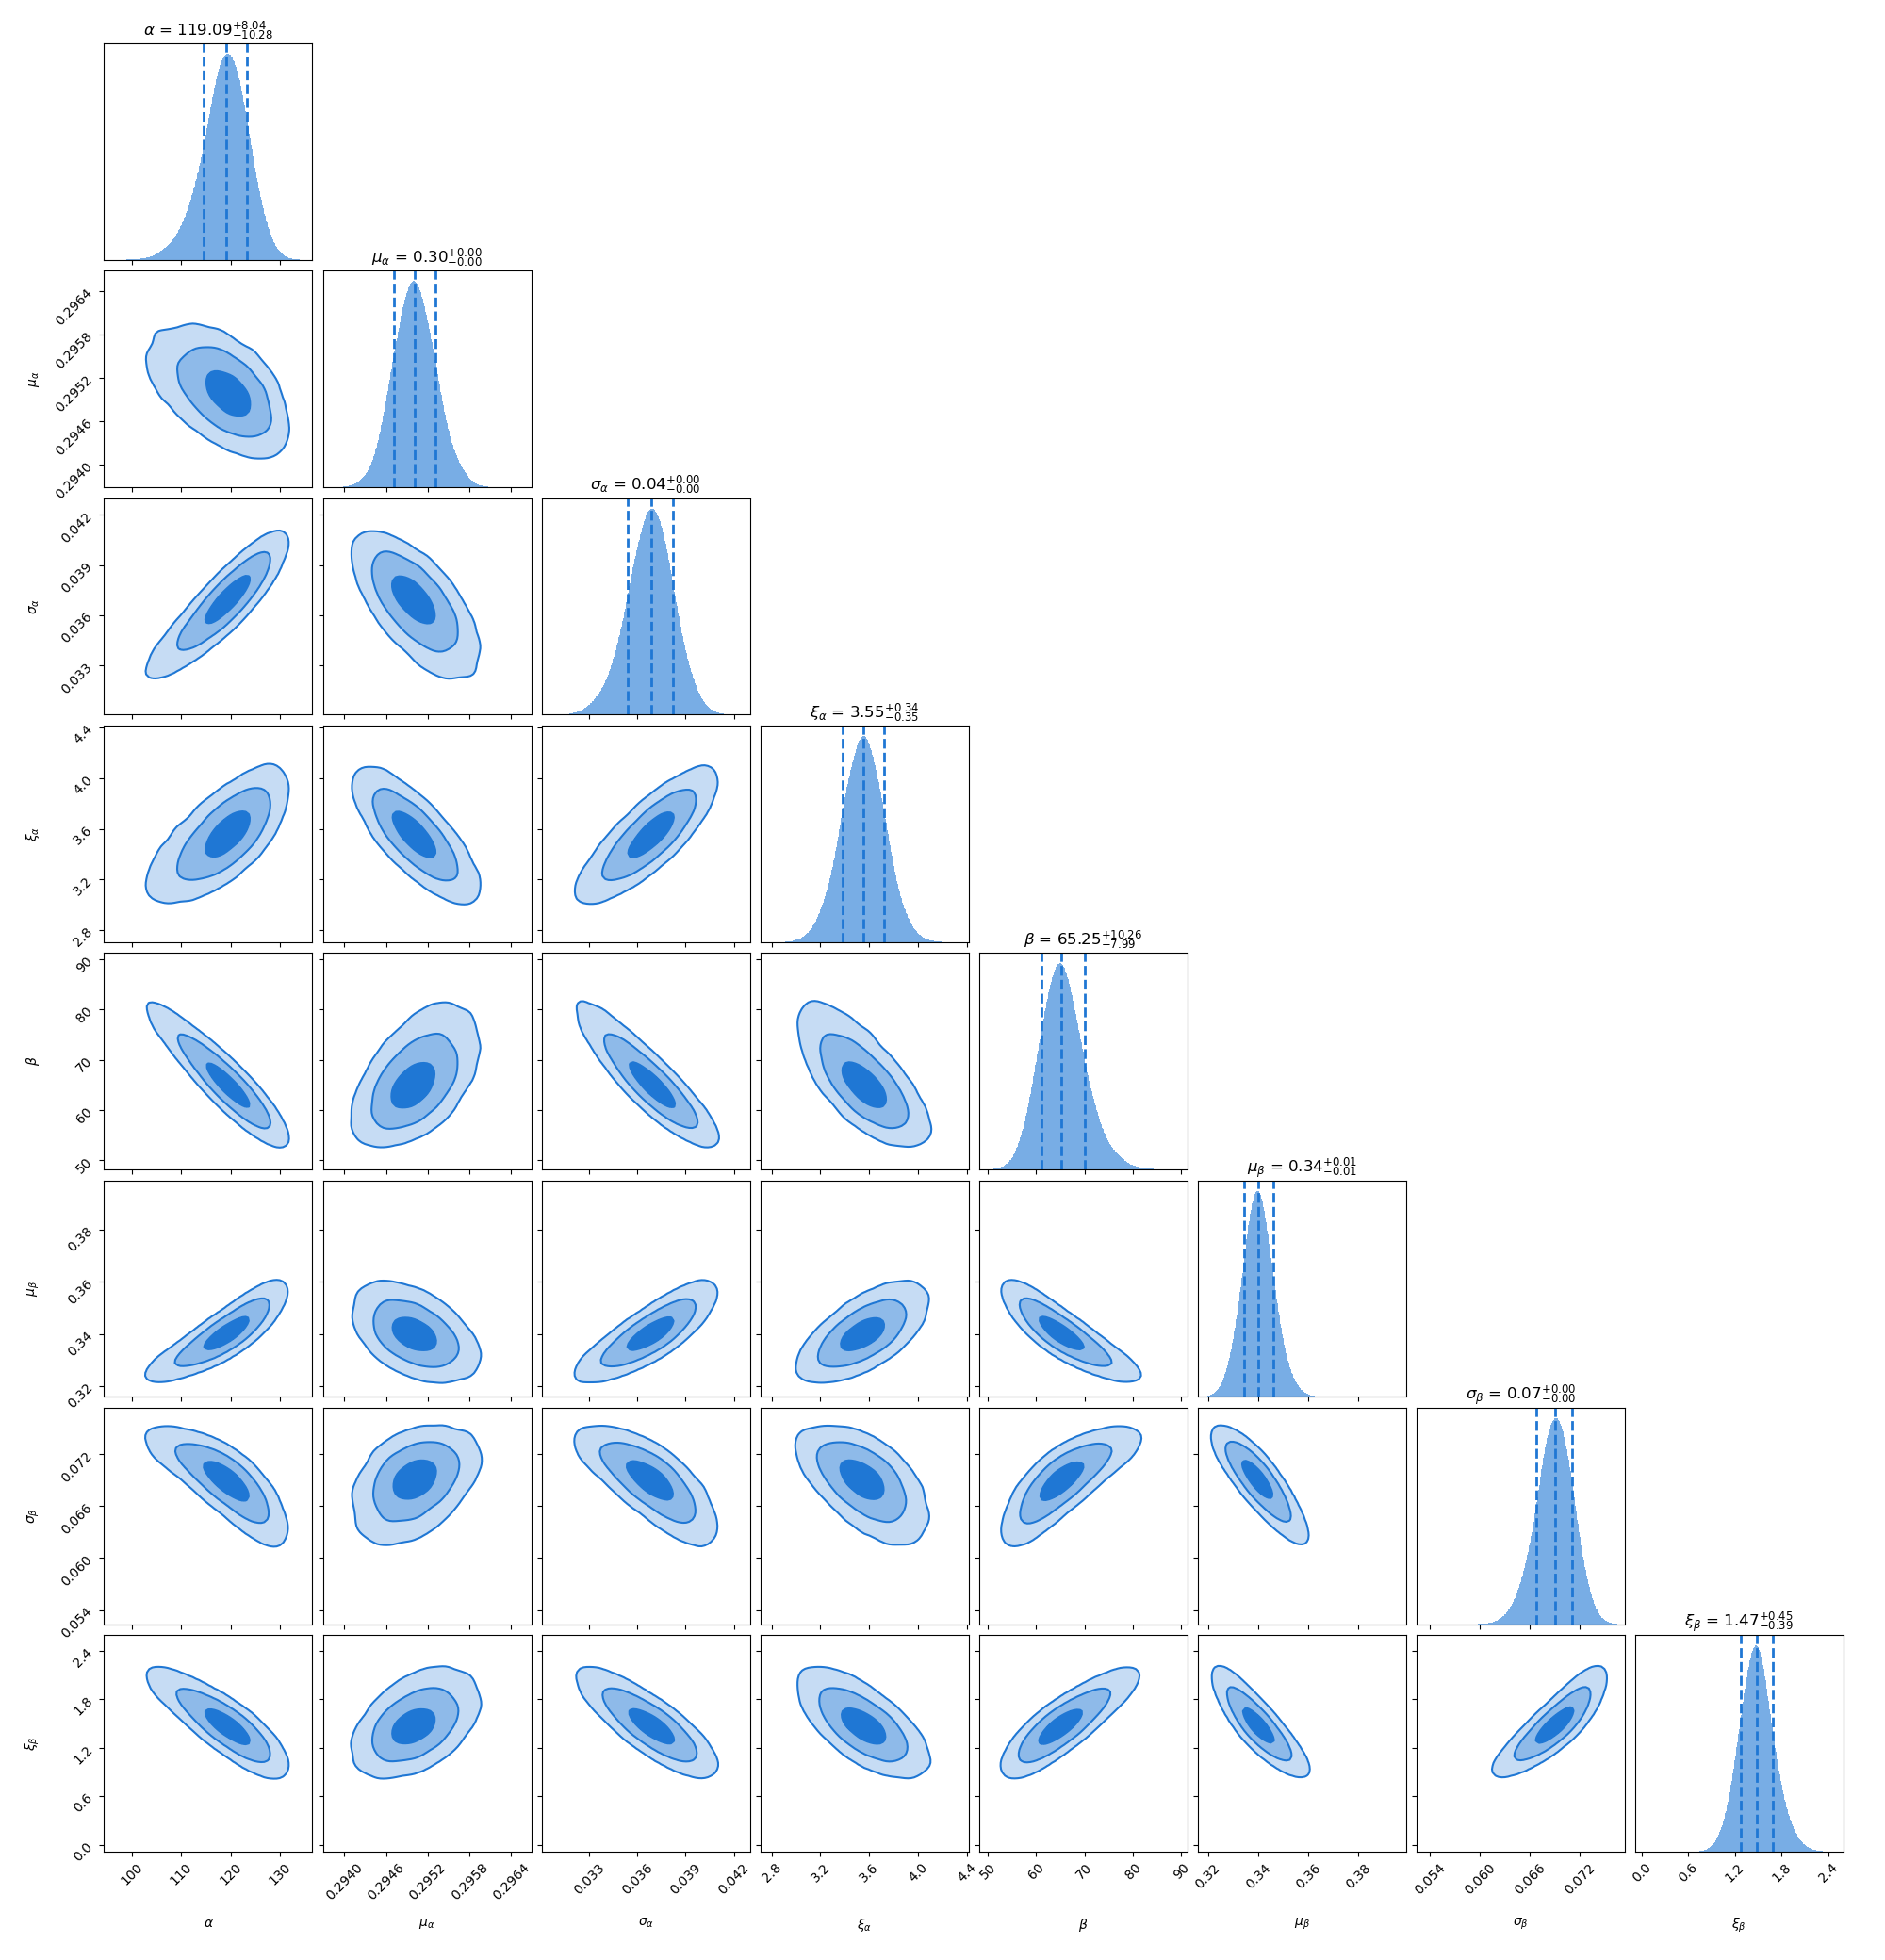

In [19]:
labels = [r'$\alpha$', r'$\mu_\alpha$', r'$\sigma_\alpha$', r'$\xi_\alpha$',
          r'$\beta$', r'$\mu_\beta$', r'$\sigma_\beta$', r'$\xi_\beta$']
nParams = len(labels)

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams,2.6*nParams)),
                              color='#1f77d4')

#### $16.5 < m_r < 17$

In [32]:
dsampler = dynesty.DynamicNestedSampler(logL_skewNorms, 
                                        prior_xforSkewNorms, 
                                        ndim=8,
                                        logl_args=(dist_16p5_17, cinv_centers),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

34967it [14:09, 41.17it/s, batch: 6 | bound: 862 | nc: 3 | ncall: 731369 | eff(%):  4.781 | loglstar: -343.318 < -335.261 < -336.852 | logz: -379.995 +/-  0.399 | stop:  0.898]            


<IPython.core.display.Javascript object>


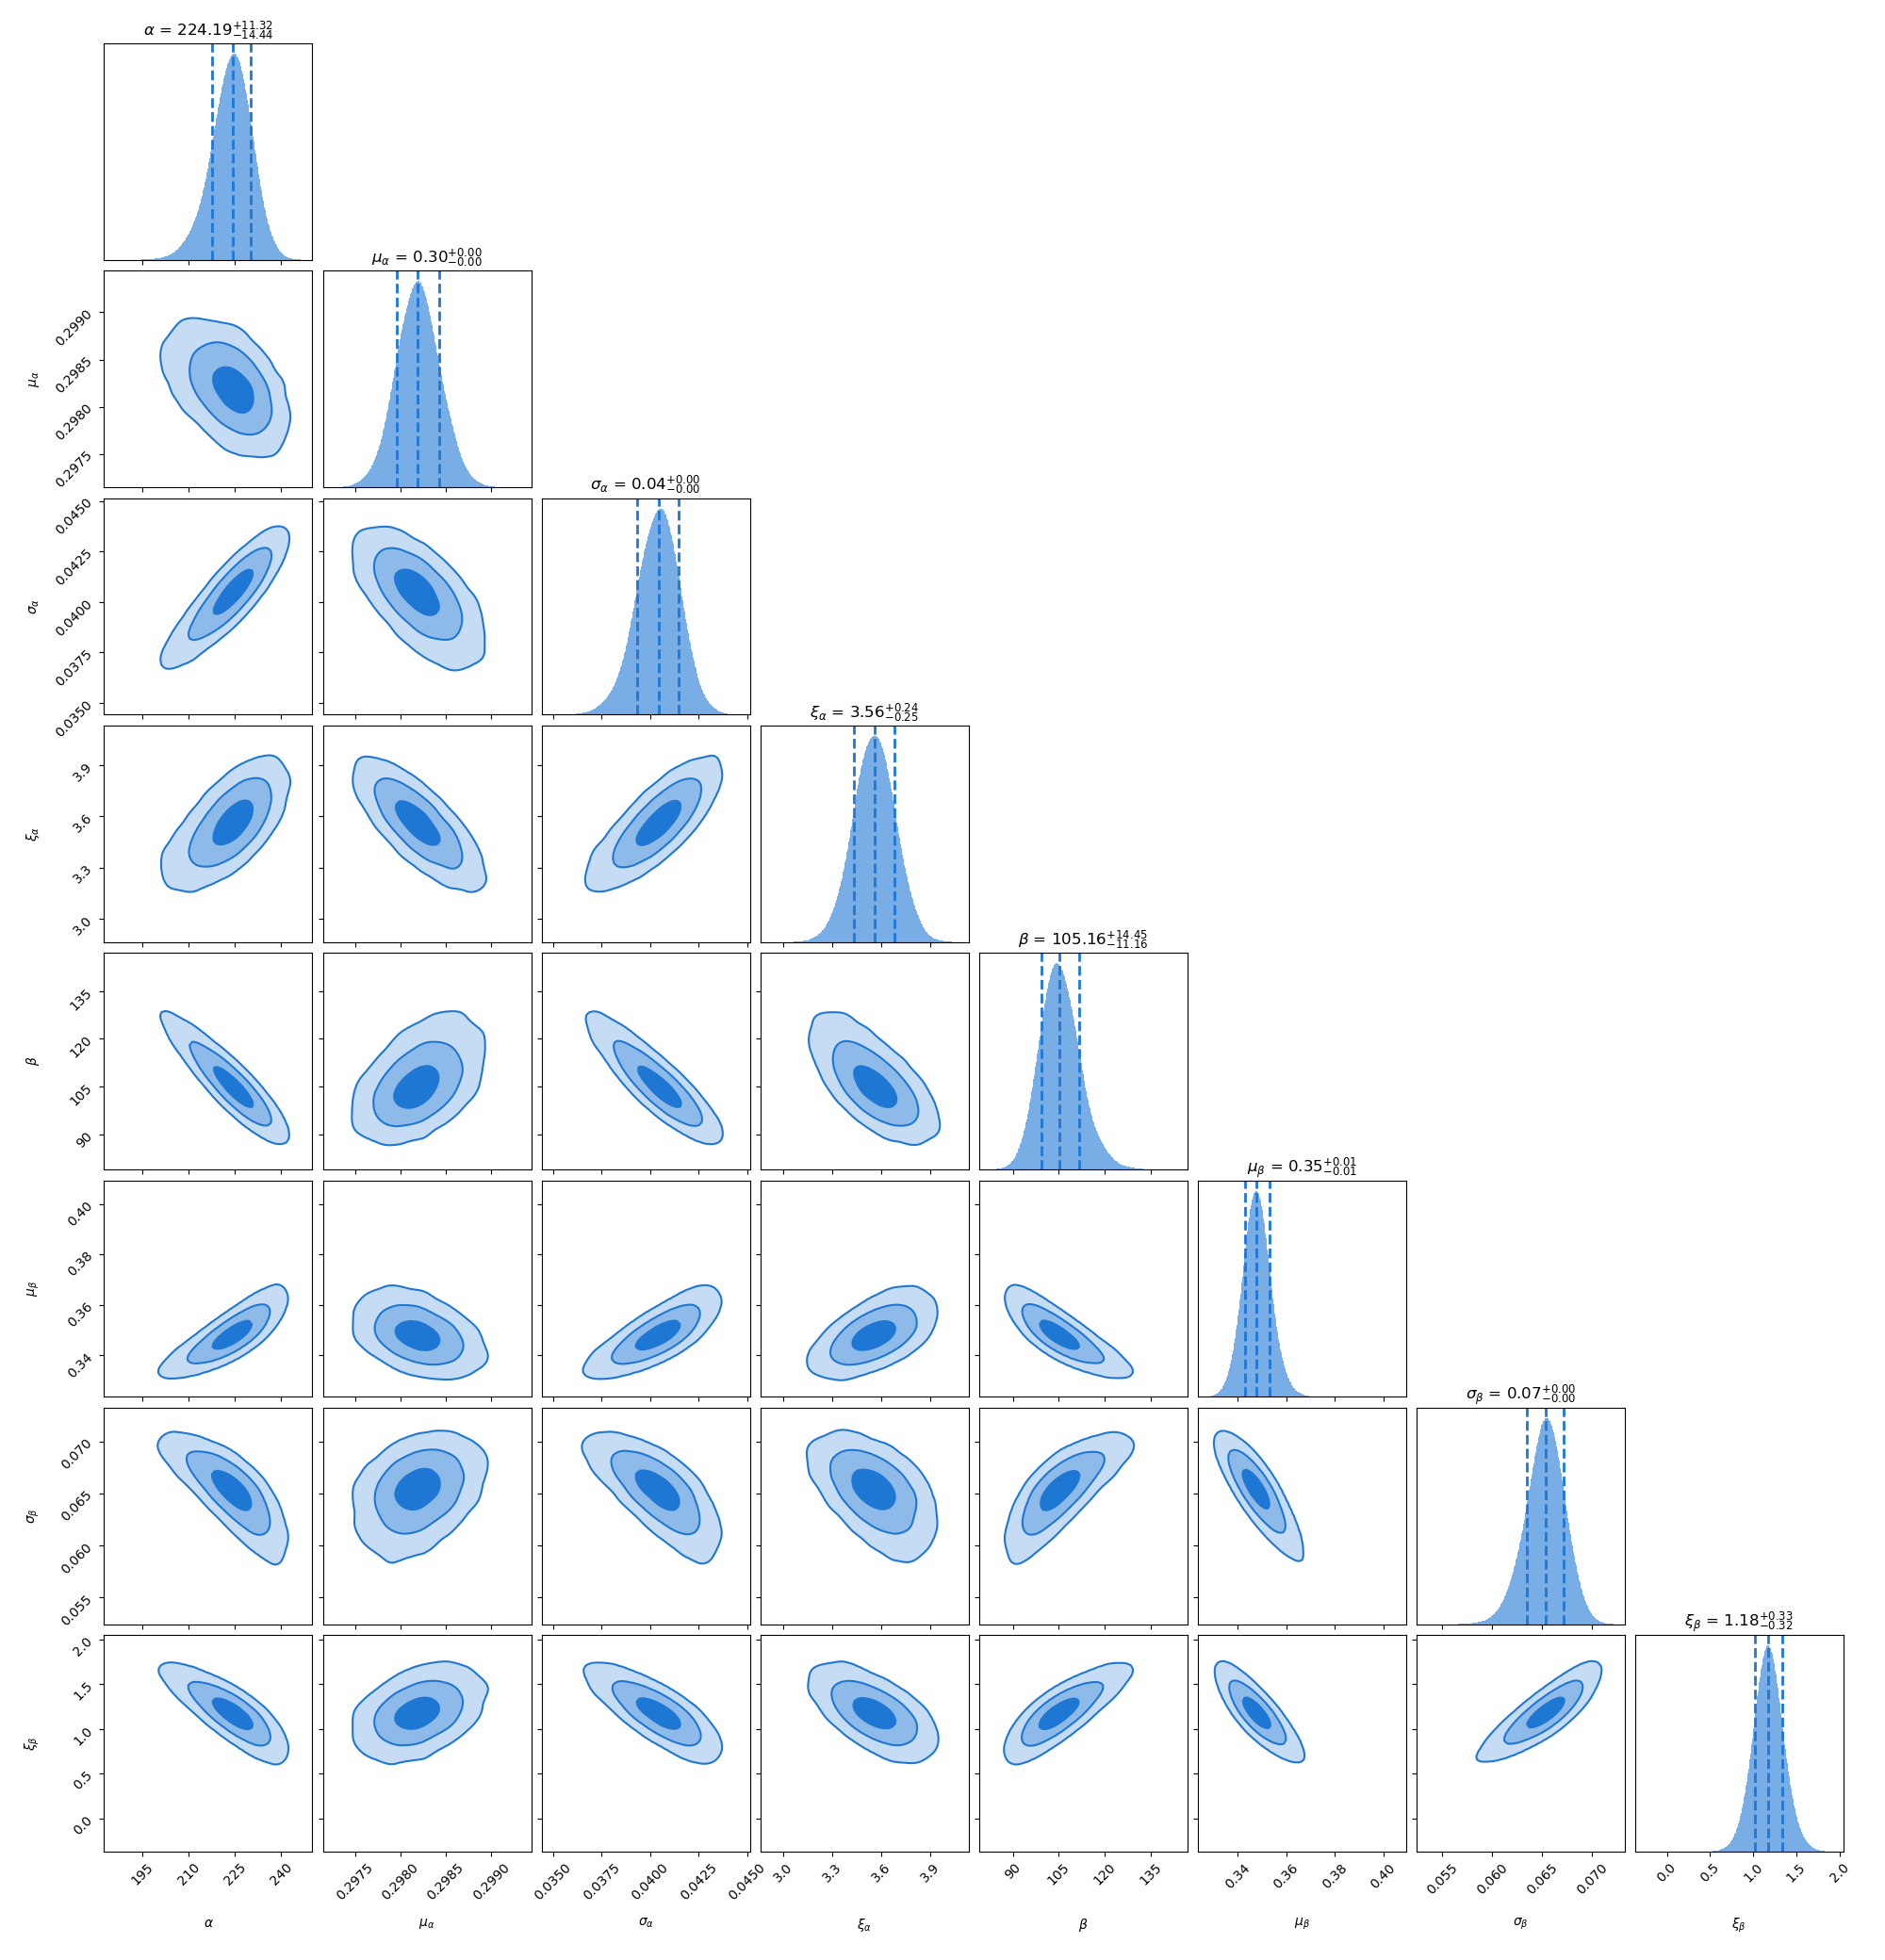

In [33]:
labels = [r'$\alpha$', r'$\mu_\alpha$', r'$\sigma_\alpha$', r'$\xi_\alpha$',
          r'$\beta$', r'$\mu_\beta$', r'$\sigma_\beta$', r'$\xi_\beta$']
nParams = len(labels)

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams,2.6*nParams)),
                              color='#1f77d4')

## $c_\text{inv}$ cut

We implement a cut on $c_\text{inv}$ to filter normal early-type galaxies from normal late-type galaxies which fall within the Park05 bounds defining normal early-type galaxies.

Instead of using fixed values (based on magnitude bins) as done in Park05, we will use the point of intersection between the two skew normal functions fit to the data.

In [53]:
from skewNorms_fit import skewNorms2_diff

#### Bright galaxies

In [54]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit.x, 
                          bracket=[0.3, 0.4], 
                          x0=(bestfit.x[1] + 2*bestfit.x[2]))

print(rootResults)

cinv_bright = rootResults.root

#cinv_bright = bestfit.x[1] + 3*bestfit.x[2]

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 0.36389885134100214


#### $16 < m_r < 16.5$

In [55]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16_16p5.x, 
                          bracket=[0.3, 0.4], 
                          x0=(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2]))

print(rootResults)

cinv_16_16p5 = rootResults.root

#cinv_16_16p5 = bestfit_16_16p5.x[1] + 3*bestfit_16_16p5.x[2]

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.37696747603194236


#### $16.5 < m_r < 17$

In [56]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16p5_17.x, 
                          bracket=[0.3, 0.4], 
                          x0=(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2]))

print(rootResults)

cinv_16p5_17 = rootResults.root

#cinv_16p5_17 = bestfit_16p5_17.x[1] + 3*bestfit_16p5_17.x[2]

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3839725657693284


#### Faint galaxies

In [57]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_faint.x, 
                          bracket=[0.3, 0.4], 
                          x0=(bestfit_faint.x[1] + 2*bestfit_faint.x[2]))

print(rootResults)

cinv_faint = rootResults.root

#cinv_faint = bestfit_faint.x[1] + 3*bestfit_faint.x[2]

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3858342667856255


## Relationship between my aimc and NUV-r

<IPython.core.display.Javascript object>


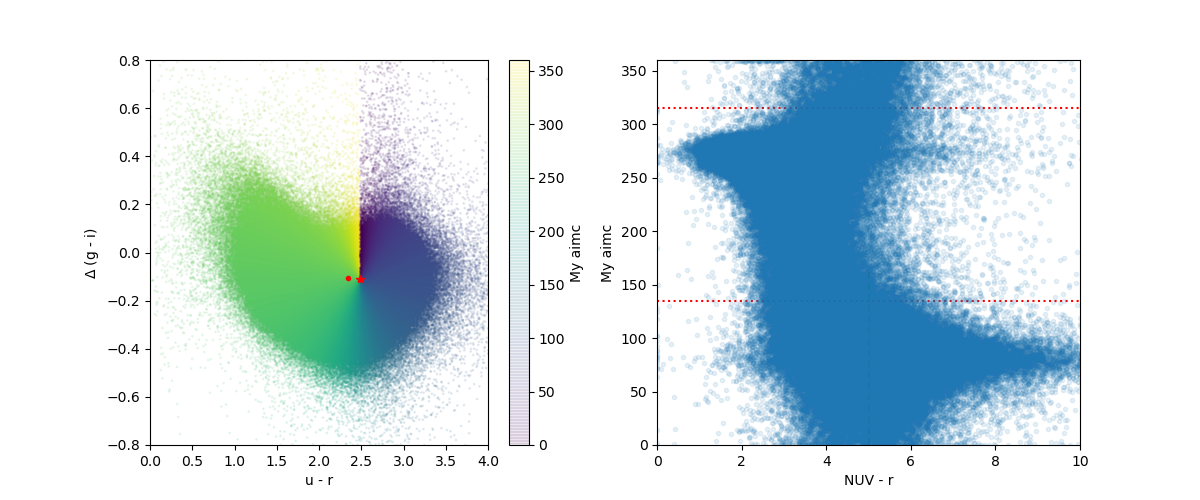

In [61]:
%matplotlib notebook

plt.figure(figsize=(12,5))


plt.subplot(121)

plt.scatter(galaxies['u_r'], galaxies['cd'], s=1, c=galaxies['my_aimc'], alpha=0.1)
plt.plot(np.mean(good_galaxies['u_r']), np.mean(good_galaxies['cd']), 'r.')
plt.plot(np.median(good_galaxies['u_r']), np.median(good_galaxies['cd']), 'r*')

#plt.plot([1,1,2.6,4], [0.8,0.3,-0.15,-0.15], 'k')

cbar = plt.colorbar()
plt.clim(0,360)
cbar.ax.set_ylabel('My aimc')

plt.axis([0, 4, -0.8, 0.8])

plt.xlabel('u - r')
plt.ylabel('$\Delta$ (g - i)')



plt.subplot(122)

plt.plot(galaxies['NUV_r'], galaxies['my_aimc'], '.', alpha=0.1)

plt.hlines([45, 315], 0, 10, colors='r', linestyle='dotted')

plt.vlines(5, 0, 165, colors='g', linestyle='dashed')

plt.axis([0, 10, 0, 360])

plt.xlabel('NUV - r')
plt.ylabel('My aimc');

It looks like I could make the limit around 135 and 315 for the cut between GV and BC.

# Define the GV

Split the galaxies up based on their location in the color - color gradient space (based on Park & Choi 2005 and Choi et al. 2010), their inverse concentration index, and their my_aimc value.

- RS: normal early-type galaxies
- GV: 
      - blue early-type galaxies
      - normal late-type galaxies within the bounds of early-types with `conx1` > some value
      - normal late-type galaxies with `my_aimc` < 135 or > 315
- BC: normal late-type galaxies with $135 <$ `my_aimc` $> 315$


## Morphological class
Based on the morphological classification of Park & Choi (2005)

#### Early-type

In [81]:
early_boolean1 = np.logical_and(galaxies['u_r'] > 1, galaxies['cd'] > 0.3)

early_boolean2_14p5_16 = np.logical_and.reduce((galaxies['u_r'] > 1, 
                                                galaxies['u_r'] <= 2.6, 
                                                galaxies['cd'] > -0.28125*galaxies['u_r'] + 0.58125))
early_boolean2_16_17 = np.logical_and.reduce((galaxies['u_r'] > 1,
                                              galaxies['u_r'] <= 2.65,
                                              galaxies['cd'] > -0.290909*galaxies['u_r'] + 0.590909))
early_boolean2_17_17p5 = np.logical_and.reduce((galaxies['u_r'] > 1,
                                                galaxies['u_r'] <= 2.7,
                                                galaxies['cd'] > -0.28236*galaxies['u_r'] + 0.582353))

early_boolean3_14p5_16 = np.logical_and(galaxies['u_r'] > 2.60, galaxies['cd'] > -0.15)
early_boolean3_16_16p5 = np.logical_and(galaxies['u_r'] > 2.65, galaxies['cd'] > -0.15)
early_boolean3_16p5_17 = np.logical_and(galaxies['u_r'] > 2.65, galaxies['cd'] > -0.25)
early_boolean3_17_17p5 = np.logical_and(galaxies['u_r'] > 2.70, galaxies['cd'] > -0.35)

early_boolean_14p5_16_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_14p5_16, 
                                                   early_boolean3_14p5_16))
early_boolean_16_16p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16_16p5))
early_boolean_16p5_17_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16p5_17))
early_boolean_17_17p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_17_17p5, 
                                                   early_boolean3_17_17p5))

# Require early-type galaxies to have inverse concentration indices smaller 
# than some value
early_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                       galaxies['conx1'] < cinv_bright)
early_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                       galaxies['conx1'] < cinv_16_16p5)
early_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                       galaxies['conx1'] < cinv_16p5_17)
early_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                       galaxies['conx1'] < cinv_faint)

# Galaxies that would normally have become late-types because of the above 
# restriction on cinv (conx1) are instead being classified as GV galaxies
gv_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                    galaxies['conx1'] >= cinv_bright)
gv_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                    galaxies['conx1'] >= cinv_16_16p5)
gv_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                    galaxies['conx1'] >= cinv_16p5_17)
gv_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                    galaxies['conx1'] >= cinv_faint)

'''
# Require early-type galaxies to have inverse concentration indices smaller than some value
early_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, galaxies['conx1'] < cinv_bright)
early_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, galaxies['conx1'] < cinv_16_16p5)
early_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, galaxies['conx1'] < cinv_16p5_17)
early_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, galaxies['conx1'] < cinv_faint)

# Galaxies that would normally have become late-types because of the above restriction on cinv (conx1) 
# are instead being classified as GV galaxies
gv_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, galaxies['conx1'] >= cinv_bright)
gv_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, galaxies['conx1'] >= cinv_16_16p5)
gv_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, galaxies['conx1'] >= cinv_16p5_17)
gv_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, galaxies['conx1'] >= cinv_faint)
''';

#### Late-type

In [82]:
late_boolean_14p5_16 = np.logical_not(early_boolean_14p5_16_area)
late_boolean_16_16p5 = np.logical_not(early_boolean_16_16p5_area)
late_boolean_16p5_17 = np.logical_not(early_boolean_16p5_17_area)
late_boolean_17_17p5 = np.logical_not(early_boolean_17_17p5_area)

In [83]:
early_galaxies = vstack([galaxies[np.logical_and(boolean_14p5_16, early_boolean_14p5_16)], 
                         galaxies[np.logical_and(boolean_16_16p5, early_boolean_16_16p5)],
                         galaxies[np.logical_and(boolean_16p5_17, early_boolean_16p5_17)],
                         galaxies[np.logical_and(boolean_17_17p5, early_boolean_17_17p5)]])

late_galaxies_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, late_boolean_14p5_16),
                                              np.logical_and(boolean_16_16p5, late_boolean_16_16p5),
                                              np.logical_and(boolean_16p5_17, late_boolean_16p5_17),
                                              np.logical_and(boolean_17_17p5, late_boolean_17_17p5)))

In [84]:
gv_early_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, gv_boolean_14p5_16), 
                                         np.logical_and(boolean_16_16p5, gv_boolean_16_16p5), 
                                         np.logical_and(boolean_16p5_17, gv_boolean_16p5_17), 
                                         np.logical_and(boolean_17_17p5, gv_boolean_17_17p5)))

## Morphological type
Based on the classification by Choi et al. (2010)

#### Normal late type

In [86]:
normal_late_boolean1 = np.logical_and.reduce((galaxies['u_r'] > 1.8,
                                              galaxies['u_r'] < 3.5,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 0.5))
normal_late_boolean2 = np.logical_and.reduce((galaxies['u_r'] <= 1.8,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 1))

normal_late_boolean = np.logical_and(late_galaxies_boolean, 
                                     np.logical_or(normal_late_boolean1, normal_late_boolean2))

In [88]:
gv_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                np.logical_or(galaxies['my_aimc'] <= 135, 
                                                              galaxies['my_aimc'] >= 315), 
                                                np.logical_not(gv_early_boolean)))

bc_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                np.logical_and(galaxies['my_aimc'] > 135, 
                                                               galaxies['my_aimc'] < 315), 
                                                np.logical_not(gv_early_boolean)))

#### Normal early type

In [101]:
normal_early_boolean = np.logical_and.reduce((early_galaxies['u_r'] > 2.5,
                                              early_galaxies['u_r'] < 3.5,
                                              early_galaxies['cd'] > -0.7, 
                                              early_galaxies['cd'] < 1))
'''
gv_normal_early_boolean = np.logical_and.reduce((early_galaxies['u_r'] > 2.5, 
                                                 early_galaxies['u_r'] < 3.5, 
                                                 early_galaxies['cd'] > -0.7, 
                                                 early_galaxies['cd'] < 1, 
                                                 early_galaxies['my_aimc'] >= 135, 
                                                 early_galaxies['my_aimc'] <= 315))
''';

#### Blue early type

In [90]:
blue_early_boolean = np.logical_and.reduce((early_galaxies['u_r'] < 2.5,
                                            early_galaxies['cd'] > -0.7,
                                            early_galaxies['cd'] < 1))

In [91]:
normal_late_galaxies = galaxies[normal_late_boolean]
normal_early_galaxies = early_galaxies[normal_early_boolean]
blue_early_galaxies = early_galaxies[blue_early_boolean]

In [102]:
RS_galaxies = early_galaxies[normal_early_boolean]

GV_galaxies = vstack([blue_early_galaxies, 
                      galaxies[gv_early_boolean], 
                      galaxies[gv_normal_late_boolean]])

BC_galaxies = galaxies[bc_normal_late_boolean]

Check to make sure that there are no galaxies in multiple categories

In [103]:
################################################################################
# RS - GV overlap
#-------------------------------------------------------------------------------
rs_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in RS_galaxies['index']:
        rs_gv_overlap += 1
    
print('Overlap between RS and GV:', rs_gv_overlap)
################################################################################

Overlap between RS and GV: 0


In [104]:
################################################################################
# RS - BC overlap
#-------------------------------------------------------------------------------
rs_bc_overlap = 0

for i in range(len(RS_galaxies)):
    if RS_galaxies['index'][i] in BC_galaxies['index']:
        rs_bc_overlap += 1
    
print('Overlap between RS and BC:', rs_bc_overlap)
################################################################################

Overlap between RS and BC: 0


In [105]:
################################################################################
# BC - GV overlap
#-------------------------------------------------------------------------------
bc_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in BC_galaxies['index']:
        bc_gv_overlap += 1
    
print('Overlap between BC and GV:', bc_gv_overlap)
################################################################################

Overlap between BC and GV: 0


# Color distributions

In [96]:
ur_bins = np.linspace(0,4.5,100)
NUVr_bins = np.linspace(0,10,100)

<IPython.core.display.Javascript object>


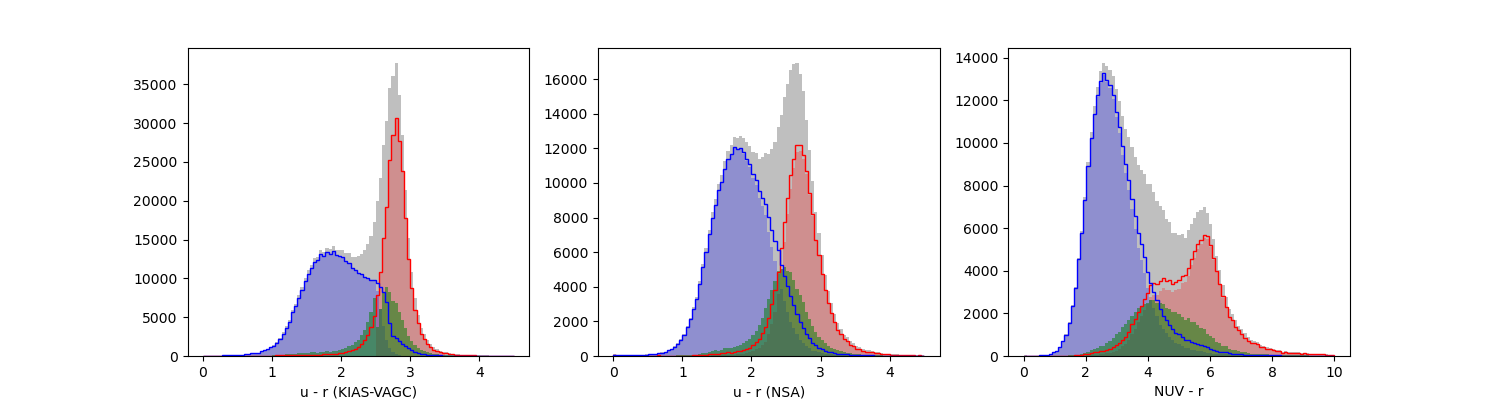

In [110]:
%matplotlib notebook

plt.figure(figsize=(15,4))


plt.subplot(131)

plt.hist(galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(late_galaxies['u_r'], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')




plt.subplot(132)

plt.hist(galaxies['u_r_NSA'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_NSA'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_NSA'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_NSA'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_NSA'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(late_galaxies['u_r_NSA'], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')




plt.subplot(133)

plt.hist(galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'], bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(late_galaxies['NUV_r'], bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r');

What are the `my_aimc` values of the previously early-type galaxies?

<IPython.core.display.Javascript object>


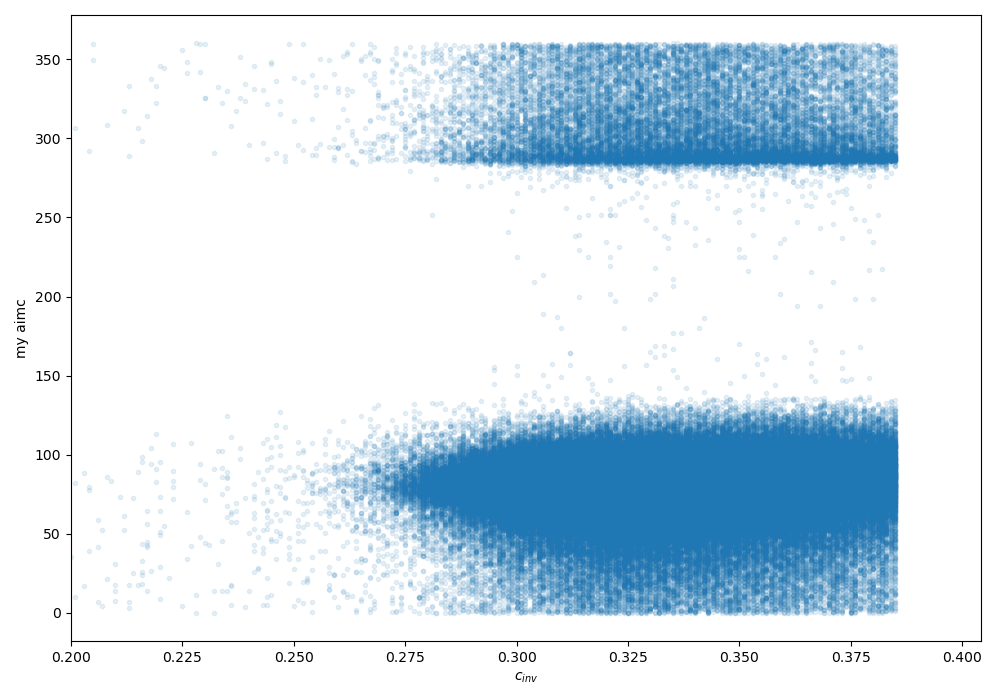

In [98]:
%matplotlib notebook

plt.figure(figsize=(10,7))

plt.plot(early_galaxies['conx1'], early_galaxies['my_aimc'], '.', alpha=0.1)

plt.xlim(xmin=0.2)

plt.xlabel('$c_{inv}$')

'''
plt.scatter(early_galaxies['NUV_r'], early_galaxies['my_aimc'], c=early_galaxies['conx1'], s=2, alpha=0.2)

cbar = plt.colorbar()
plt.clim(0.3, 0.5)
cbar.ax.set_ylabel('$c_{inv}$')

plt.xlabel('NUV-r')
'''
plt.ylabel('my aimc')

plt.tight_layout();

# CMDs

<IPython.core.display.Javascript object>


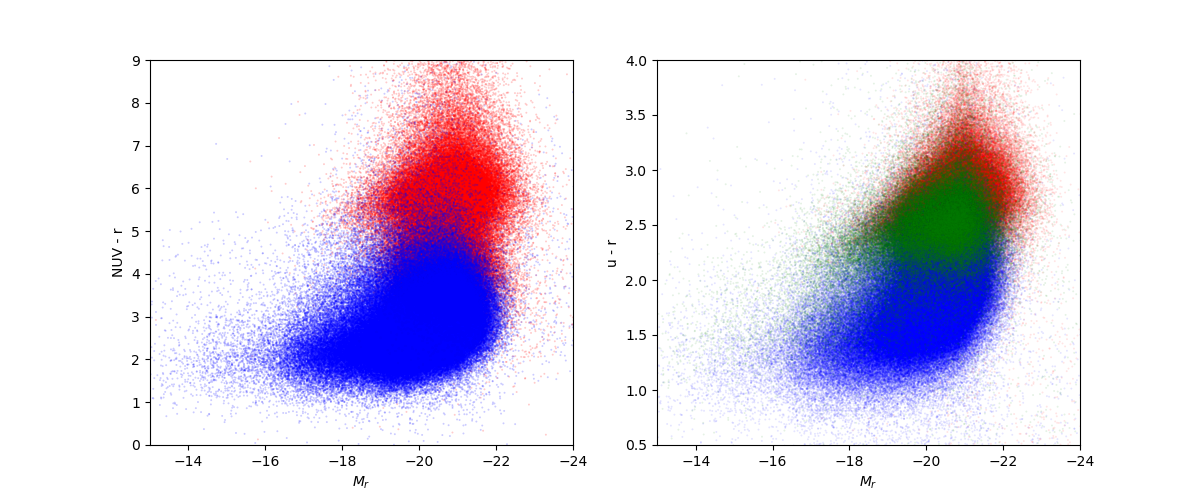

In [107]:
%matplotlib notebook

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(RS_galaxies['rabsmag_NSA'], RS_galaxies['NUV_r'], s=2, c='r', 
            alpha=0.2, edgecolors='none')
plt.scatter(BC_galaxies['rabsmag_NSA'], BC_galaxies['NUV_r'], s=2, c='b', 
            alpha=0.2, edgecolors='none')
#plt.scatter(GV_galaxies['rabsmag_NSA'], GV_galaxies['NUV_r'], s=2, c='g', 
#            alpha=0.2, edgecolors='none')
plt.xlabel('$M_r$')
plt.ylabel('NUV - r')
plt.axis([-13, -24, 0, 9])

plt.subplot(122)
plt.scatter(RS_galaxies['rabsmag_NSA'], RS_galaxies['u_r_NSA'], s=2, c='r', 
            alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['rabsmag_NSA'], BC_galaxies['u_r_NSA'], s=2, c='b', 
            alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['rabsmag_NSA'], GV_galaxies['u_r_NSA'], s=2, c='g', 
            alpha=0.1, edgecolors='none')
plt.xlabel('$M_r$')
plt.ylabel('u - r')
plt.axis([-13, -24, 0.5, 4]);

<IPython.core.display.Javascript object>


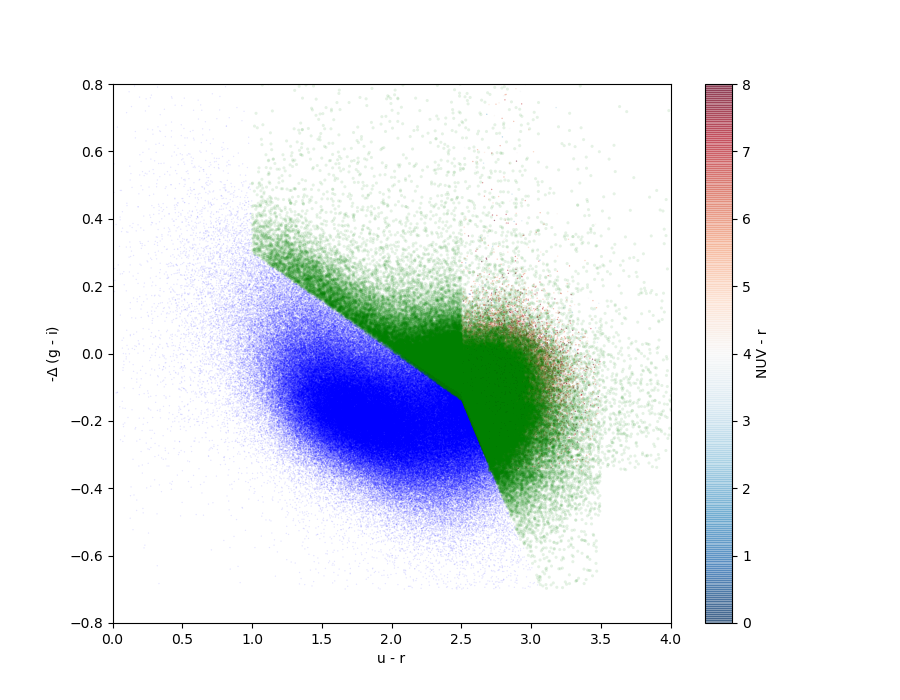

In [108]:
%matplotlib notebook

plt.figure(figsize=(9,7))

plt.scatter(RS_galaxies['u_r'], RS_galaxies['cd'], s=1, c=RS_galaxies['NUV_r'], 
            cmap=cm.RdBu_r, edgecolors='none', alpha=0.5, label='Red sequence')
cbar = plt.colorbar()
plt.clim(0,8)
cbar.ax.set_ylabel('NUV - r')

plt.scatter(BC_galaxies['u_r'], BC_galaxies['cd'], s=1, c='b', alpha=0.1, edgecolors='none', 
            label='Blue cloud')

plt.scatter(GV_galaxies['u_r'], GV_galaxies['cd'], s=5, c='g', alpha=0.1, edgecolors='none', 
            label='Green valley')

plt.xlabel('u - r')
plt.ylabel('-$\Delta$ (g - i)')

#plt.legend()

plt.axis([0, 4, -0.8, 0.8]);

# Compare aimc to NUV-r

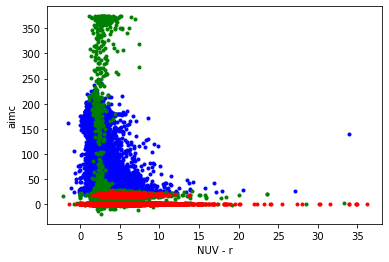

In [109]:
%matplotlib inline

plt.figure()

#plt.plot(galaxies['NUV_r'], galaxies['aimc'], '.')
plt.plot(BC_galaxies['NUV_r'], BC_galaxies['aimc'], 'b.')
plt.plot(GV_galaxies['NUV_r'], GV_galaxies['aimc'], 'g.')
plt.plot(RS_galaxies['NUV_r'], RS_galaxies['aimc'], 'r.')

plt.xlabel('NUV - r')
plt.ylabel('aimc');

# Testing my function of the classification

In [3]:
from CMD_classification import CMD_class_median

In [4]:
galaxies['CMD_class'] = CMD_class_median(galaxies['u_r'], galaxies['cd'], galaxies['conx1'], galaxies['prmag'])

### Separate by CMD class

In [5]:
BC = galaxies[galaxies['CMD_class'] == 1]

GV = galaxies[galaxies['CMD_class'] == 2]

RS = galaxies[galaxies['CMD_class'] == 3]

### Color distribution

<IPython.core.display.Javascript object>


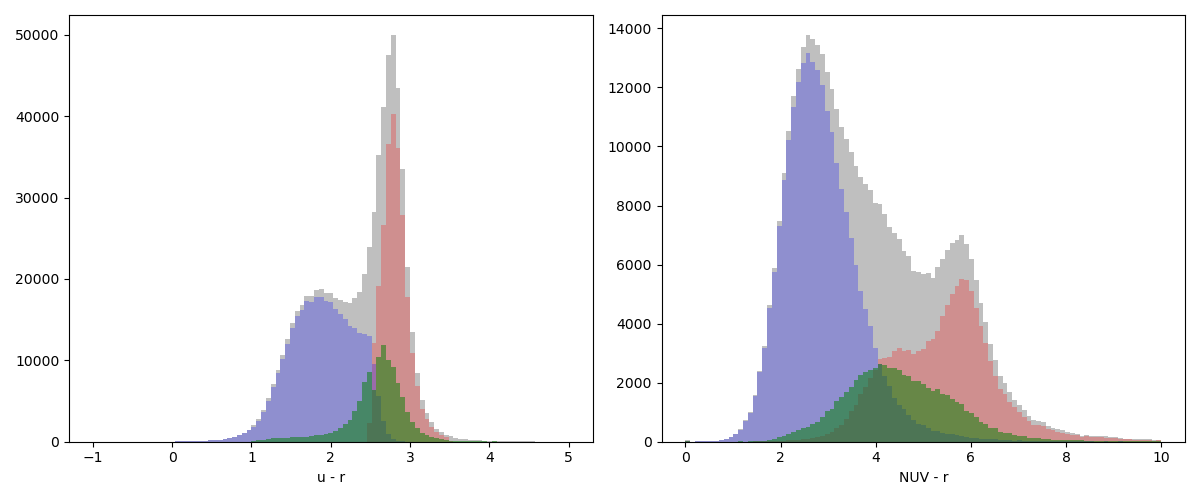

In [9]:
%matplotlib notebook

plt.figure(figsize=(12,5))


x_range = np.linspace(-1,5,100)

plt.subplot(121)
plt.hist(galaxies['u_r'], bins=x_range, alpha=0.25, facecolor='k')
plt.hist(RS['u_r'], bins=x_range, alpha=0.25, facecolor='r')
plt.hist(BC['u_r'], bins=x_range, alpha=0.25, facecolor='b')
plt.hist(GV['u_r'], bins=x_range, alpha=0.5, facecolor='g')

plt.xlabel('u - r')



x_range_NUVr = np.linspace(0,10,100)

plt.subplot(122)
plt.hist(galaxies['NUV_r'], bins=x_range_NUVr, alpha=0.25, facecolor='k')
plt.hist(RS['NUV_r'], bins=x_range_NUVr, alpha=0.25, facecolor='r')
plt.hist(BC['NUV_r'], bins=x_range_NUVr, alpha=0.25, facecolor='b')
plt.hist(GV['NUV_r'], bins=x_range_NUVr, alpha=0.5, facecolor='g')

plt.xlabel('NUV - r')


plt.tight_layout();

### CMDs

<IPython.core.display.Javascript object>


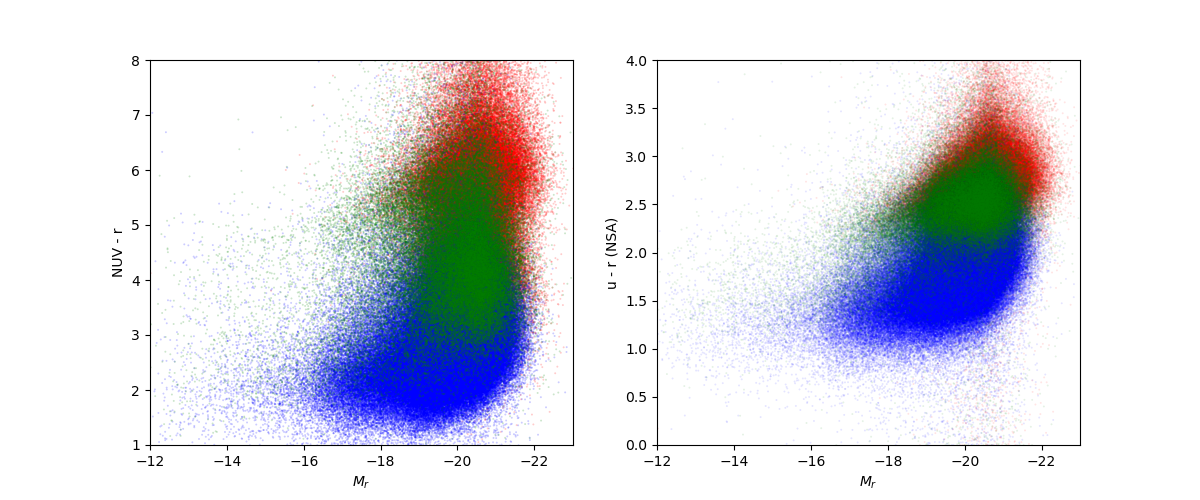

In [7]:
%matplotlib notebook

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(RS['rabsmag'], RS['NUV_r'], s=2, c='r', alpha=0.2, edgecolors='none')
plt.scatter(BC['rabsmag'], BC['NUV_r'], s=2, c='b', alpha=0.2, edgecolors='none')
plt.scatter(GV['rabsmag'], GV['NUV_r'], s=2, c='g', alpha=0.2,edgecolors='none')

plt.xlabel('$M_r$')
plt.ylabel('NUV - r')

plt.axis([-12, -23, 1, 8])




plt.subplot(122)
plt.scatter(RS['rabsmag'], RS['u_r_NSA'], s=2, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC['rabsmag'], BC['u_r_NSA'], s=2, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV['rabsmag'], GV['u_r_NSA'], s=2, c='g', alpha=0.1, edgecolors='none')

plt.xlabel('$M_r$')
plt.ylabel('u - r (NSA)')

plt.axis([-12, -23, 0, 4]);

<IPython.core.display.Javascript object>


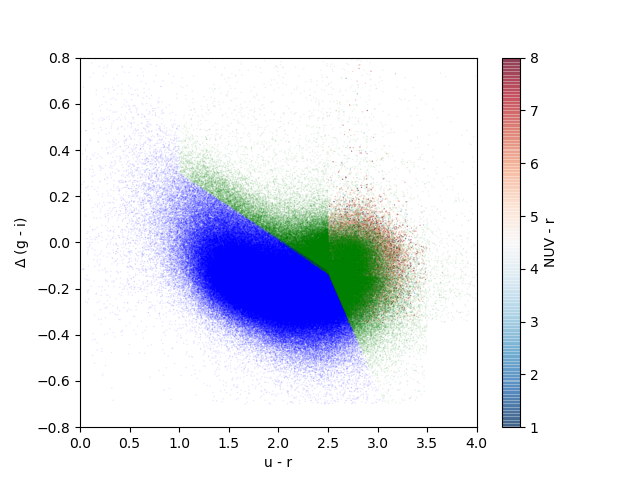

In [8]:
plt.figure()

plt.scatter(RS['u_r'], RS['cd'], s=1, c=RS['NUV_r'], 
            cmap=cm.RdBu_r, edgecolors='none', alpha=0.5, label='Red sequence')
cbar = plt.colorbar()
plt.clim(1,8)
cbar.ax.set_ylabel('NUV - r')

plt.scatter(BC['u_r'], BC['cd'], s=1, c='b', alpha=0.1, edgecolors='none', 
            label='Blue cloud')

plt.scatter(GV['u_r'], GV['cd'], s=1, c='g', alpha=0.1, edgecolors='none', 
            label='Green valley')

plt.xlabel('u - r')
plt.ylabel('$\Delta$ (g - i)')

#plt.legend()

plt.axis([0, 4, -0.8, 0.8]);